In [1]:
import shap
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, chi2
from scipy.stats import ttest_ind

from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold
import seaborn as sns

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score


# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import root_mean_squared_log_error

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# tunning hyperparamters model
import optuna

import joblib
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

/home/andre/Elbrus-DataScience/lessons/project_elb/house-prices-kaggle/House-prices-kaggle/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Классы
class HousePricesSmartImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stats_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.stats_ = {}
        
        # 1. Медиана LotFrontage по районам
        if 'LotFrontage' in X.columns and 'Neighborhood' in X.columns:
            self.stats_['lot_medians'] = X.groupby('Neighborhood')['LotFrontage'].median().to_dict()
            self.stats_['lot_overall'] = X['LotFrontage'].median()

        # 2. Мода MSZoning по подклассу здания (MSSubClass)
        if 'MSZoning' in X.columns and 'MSSubClass' in X.columns:
            mode_series = X.groupby('MSSubClass')['MSZoning'].agg(
                lambda x: x.mode().iat[0] if not x.mode().empty else np.nan
            )
            self.stats_['zoning_modes'] = mode_series.to_dict()
            
            overall_zoning_mode = X['MSZoning'].mode()
            self.stats_['zoning_overall'] = overall_zoning_mode.iat[0] if not overall_zoning_mode.empty else None
            
        return self

    def transform(self, X):
        X = X.copy()

        # 1. Заполнение LotFrontage через Neighborhood
        if 'LotFrontage' in X.columns:
            X['LotFrontage'] = X['LotFrontage'].fillna(X['Neighborhood'].map(self.stats_.get('lot_medians', {})))
            X['LotFrontage'] = X['LotFrontage'].fillna(self.stats_.get('lot_overall'))

        # 2. Заполнение MSZoning через MSSubClass
        if 'MSZoning' in X.columns:
            X['MSZoning'] = X['MSZoning'].fillna(X['MSSubClass'].map(self.stats_.get('zoning_modes', {})))
            X['MSZoning'] = X['MSZoning'].fillna(self.stats_.get('zoning_overall'))

        # 3. Заполнение GarageYrBlt годом постройки самого дома
        if 'GarageYrBlt' in X.columns and 'YearBuilt' in X.columns:
            X['GarageYrBlt'] = X['GarageYrBlt'].fillna(X['YearBuilt'])

        # 4. Заполнение Functional константой 'Typ'
        if 'Functional' in X.columns:
            X['Functional'] = X['Functional'].fillna('Typ')

        return X
    

# добавление признаков
class HousePricesFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # 1. Общая площадь
        X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
        
        # # 2. Общее количество санузлов
        # X['TotalBath'] = (X['FullBath'] + (0.5 * X['HalfBath']) + 
        #                   X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))
        
        # 3. Возраст и время с ремонта
        X['HouseAge'] = X['YrSold'] - X['YearBuilt']
        X['YearsSinceRemodel'] = X['YrSold'] - X['YearRemodAdd']
        
        # 4. Бинарный признак: новый дом или нет
        X['IsNew'] = (X['YearBuilt'] == X['YrSold']).astype(int)
        
        return X

    def get_feature_names_out(self, input_features=None):
        # Добавляем новые имена к списку входящих колонок
        new_cols = ['TotalSF', 'YearsSinceRemodel', 'HouseAge',  'IsNew']  # 'YearsSinceRemodel','TotalBath'
        return list(input_features) + new_cols
    

# 2. РЕШЕНИЕ ПРОБЛЕМЫ CATBOOST Один правильный класс тегов
class CatBoostTags:
    @property
    def estimator_type(self): 
        return "regressor"
    def __getattr__(self, name): 
        return None

    

In [3]:
# ФУНКЦИИ
# печать числовых признаков
def plot_numer(dfp):    
    cols = dfp.select_dtypes(include='number').columns
    n_cols = 3
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() # Превращаем матрицу осей в плоский список

    for i, col in enumerate(cols):
        sns.histplot(dfp[col], ax=axes[i], kde=True)
        axes[i].set_title(f'Распределение {col}')

    # Удаляем пустые графики, если колонок меньше, чем ячеек в сетке
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# печать категориальных признаков
def plot_cat(dfp):
    cols = dfp.select_dtypes(include='object').columns
    n_cols = 3
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        # Используем countplot для категориальных данных
        sns.countplot(data=dfp, x=col, ax=axes[i], palette='viridis', hue=col, legend=False)
        
        axes[i].set_title(f'Частота: {col}', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45) # Поворачиваем текст, чтобы не накладывался
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Количество')

    # Удаляем пустые ячейки
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [4]:
pd.set_option('display.max_rows', 100)      # показывать до 50 строк
pd.set_option('display.max_columns', 50)    # показывать до 50 столбцов
pd.set_option('display.width', None)        # автоматическая ширина вывода (без переносов)
# pd.set_option('display.max_colwidth', None) # полная ширина содержимого ячейки

In [5]:
dir_path = r"data/"
train = pd.read_csv(dir_path + 'train.csv')

test = pd.read_csv(dir_path + 'test.csv')

# sample_submission = pd.read_csv(dir_path + 'sample_submission.csv')

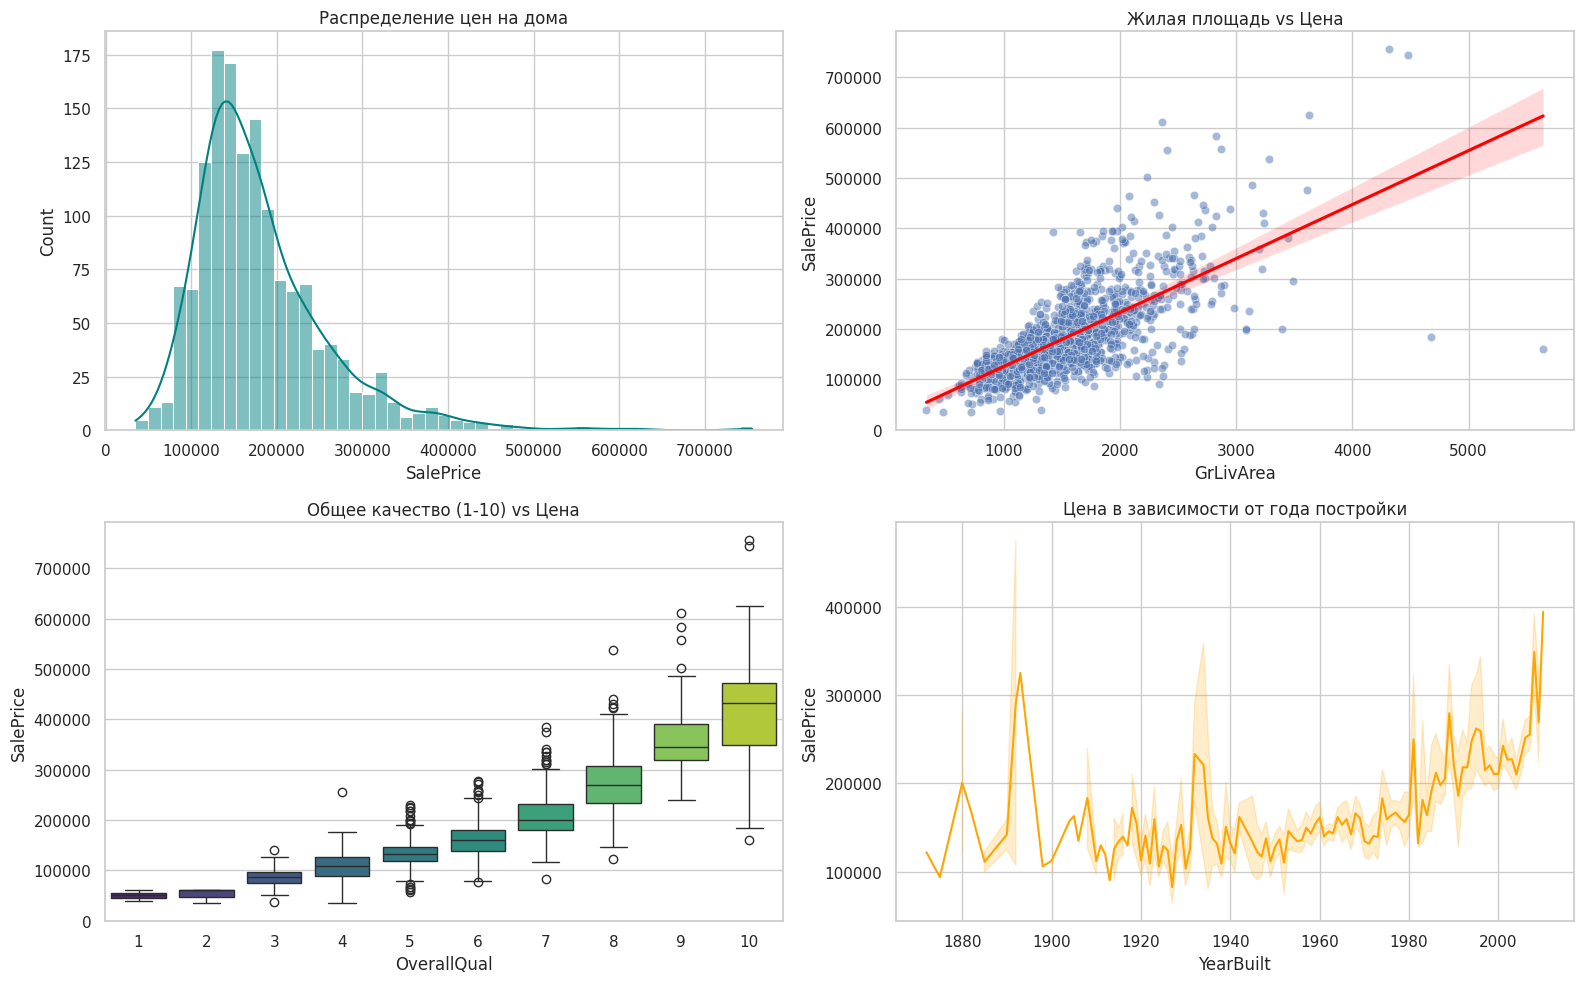

In [6]:
# Настройка стиля
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# 1. Распределение цены
plt.subplot(2, 2, 1)
sns.histplot(train['SalePrice'], kde=True, color='teal')
plt.title('Распределение цен на дома')

# 2. Площадь vs Цена (Главная зависимость)
plt.subplot(2, 2, 2)
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train, alpha=0.5)
sns.regplot(x='GrLivArea', y='SalePrice', data=train, scatter=False, color='red')
plt.title('Жилая площадь vs Цена')


# 3. Качество vs Цена (Главный категориальный признак)
plt.subplot(2, 2, 3)
sns.boxplot(x='OverallQual', y='SalePrice', data=train, palette='viridis')
plt.title('Общее качество (1-10) vs Цена')


# 4. Год постройки vs Цена (Динамика рынка)
plt.subplot(2, 2, 4)
sns.lineplot(x='YearBuilt', y='SalePrice', data=train, color='orange')
plt.title('Цена в зависимости от года постройки')


plt.tight_layout()
plt.show()

Вывод: Цены смещены вправо. Большинство домов стоят 100-200к, но есть "хвост" элитного жилья.
Вывод: Прямая зависимость. Видны 2 точки справа внизу (огромные дома за копейки) — это выбросы, их лучше удалить.
Вывод: Каждый шаг качества экспоненциально растит цену. Качество 10 имеет огромный разброс.
Вывод: Новые дома стоят дороже, но есть всплеск цен у "старых" домов.

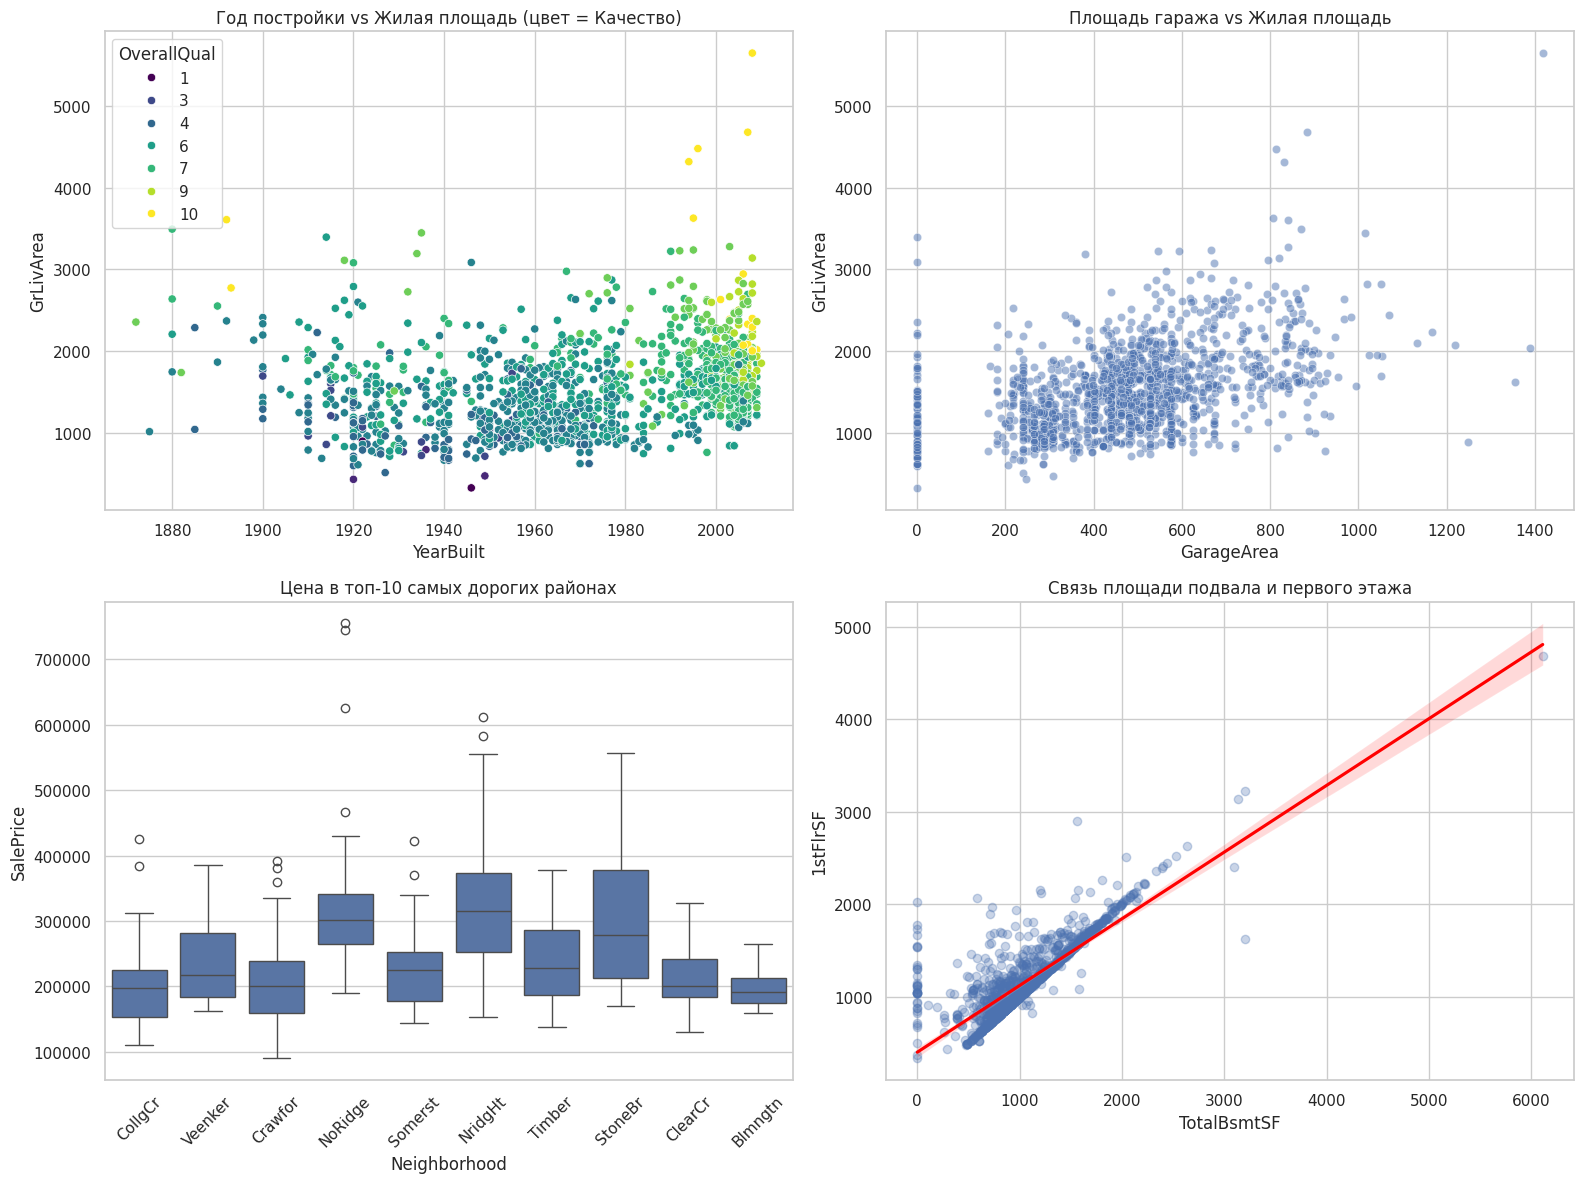

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Взаимосвязь года постройки и общей площади (строят ли сейчас дома больше?)
sns.scatterplot(data=train, x='YearBuilt', y='GrLivArea', hue='OverallQual', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Год постройки vs Жилая площадь (цвет = Качество)')

# Взаимосвязь гаража и площади дома (наличие мультиколлинеарности)
sns.scatterplot(data=train, x='GarageArea', y='GrLivArea', ax=axes[0, 1], alpha=0.5)
axes[0, 1].set_title('Площадь гаража vs Жилая площадь')

# Зависимость цены от района (Neighborhood) - топ 10 районов по цене
top_neighborhoods = train.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False).index[:10]
sns.boxplot(data=train[train['Neighborhood'].isin(top_neighborhoods)], x='Neighborhood', y='SalePrice', ax=axes[1, 0])
axes[1, 0].set_title('Цена в топ-10 самых дорогих районах')
axes[1, 0].tick_params(axis='x', rotation=45)

# Взаимосвязь общей площади и подвала
sns.regplot(data=train, x='TotalBsmtSF', y='1stFlrSF', ax=axes[1, 1], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[1, 1].set_title('Связь площади подвала и первого этажа')



plt.tight_layout()
plt.show()

Объединяем датафреймы

In [8]:
train['is_train'] = 1
test['is_train'] = 0
test['SalePrice'] = np.nan
train_ids = train['Id']
test_ids = test['Id']
train = train.drop('Id', axis=1)
test = test.drop('Id', axis=1)

union_df = pd.concat([train, test], ignore_index=True)

In [9]:
union_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  ...  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace  ...   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN  ...   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace  ...   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN  ...   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace  ...   

   FireplaceQu GarageType GarageYrBlt GarageFinish GarageCars GarageArea  \
0          NaN     Attchd      2003.0          RFn        2.0      548.0   
1           TA     Attchd      1976.0          RFn        2.0      460.0   
2           TA     Attchd      2001.0          RFn        2.0      608.0   
3           Gd     Detchd      1998.0          Unf        3.0      642.0   
4           TA     Attchd      2000.0          RFn        3.0      836.0   

  GarageQual GarageCond  PavedDrive WoodDeckSF  OpenPorchSF  EnclosedPorch  \
0         TA         TA           Y          0           61              0   
1         TA         TA           Y        298            0              0   
2         TA         TA           Y          0           42              0   
3         TA         TA           Y          0           35            272   
4         TA         TA           Y        192           84              0   

   3SsnPorch ScreenPorch PoolArea PoolQC Fence  MiscFeature  MiscVal  MoSold  \
0          0           0        0    NaN   NaN          NaN        0       2   
1          0           0        0    NaN   NaN          NaN        0       5   
2          0           0        0    NaN   NaN          NaN        0       9   
3          0           0        0    NaN   NaN          NaN        0       2   
4          0           0        0    NaN   NaN          NaN        0      12   

   YrSold  SaleType  SaleCondition  SalePrice  is_train  
0    2008        WD         Normal   208500.0         1  
1    2007        WD         Normal   181500.0         1  
2    2008        WD         Normal   223500.0         1  
3    2006        WD        Abnorml   140000.0         1  
4    2008        WD         Normal   250000.0         1  

[5 rows x 81 columns]

In [10]:
train.isna().mean().sort_values(ascending=False)

PoolQC           0.995205
MiscFeature      0.963014
Alley            0.937671
Fence            0.807534
MasVnrType       0.597260
FireplaceQu      0.472603
LotFrontage      0.177397
GarageYrBlt      0.055479
GarageFinish     0.055479
GarageQual       0.055479
GarageCond       0.055479
GarageType       0.055479
BsmtFinType2     0.026027
BsmtExposure     0.026027
BsmtFinType1     0.025342
BsmtQual         0.025342
BsmtCond         0.025342
MasVnrArea       0.005479
Electrical       0.000685
BldgType         0.000000
HouseStyle       0.000000
Condition1       0.000000
Neighborhood     0.000000
LandSlope        0.000000
Condition2       0.000000
Utilities        0.000000
LandContour      0.000000
LotShape         0.000000
Street           0.000000
MSZoning         0.000000
LotArea          0.000000
MSSubClass       0.000000
LotConfig        0.000000
OverallQual      0.000000
ExterCond        0.000000
BsmtFinSF2       0.000000
ExterQual        0.000000
TotalBsmtSF      0.000000
Heating     

In [11]:
union_df.isna().mean().sort_values(ascending=False)

PoolQC           0.996574
MiscFeature      0.964029
Alley            0.932169
Fence            0.804385
MasVnrType       0.605002
SalePrice        0.499829
FireplaceQu      0.486468
LotFrontage      0.166495
GarageCond       0.054471
GarageFinish     0.054471
GarageYrBlt      0.054471
GarageQual       0.054471
GarageType       0.053786
BsmtExposure     0.028092
BsmtCond         0.028092
BsmtQual         0.027749
BsmtFinType2     0.027407
BsmtFinType1     0.027064
MasVnrArea       0.007879
MSZoning         0.001370
Functional       0.000685
BsmtFullBath     0.000685
Utilities        0.000685
BsmtHalfBath     0.000685
SaleType         0.000343
BsmtFinSF1       0.000343
BsmtUnfSF        0.000343
Electrical       0.000343
TotalBsmtSF      0.000343
Exterior2nd      0.000343
KitchenQual      0.000343
GarageCars       0.000343
GarageArea       0.000343
Exterior1st      0.000343
BsmtFinSF2       0.000343
OverallQual      0.000000
Condition2       0.000000
Condition1       0.000000
HouseStyle  

строим гистограмму распределения цены жилья

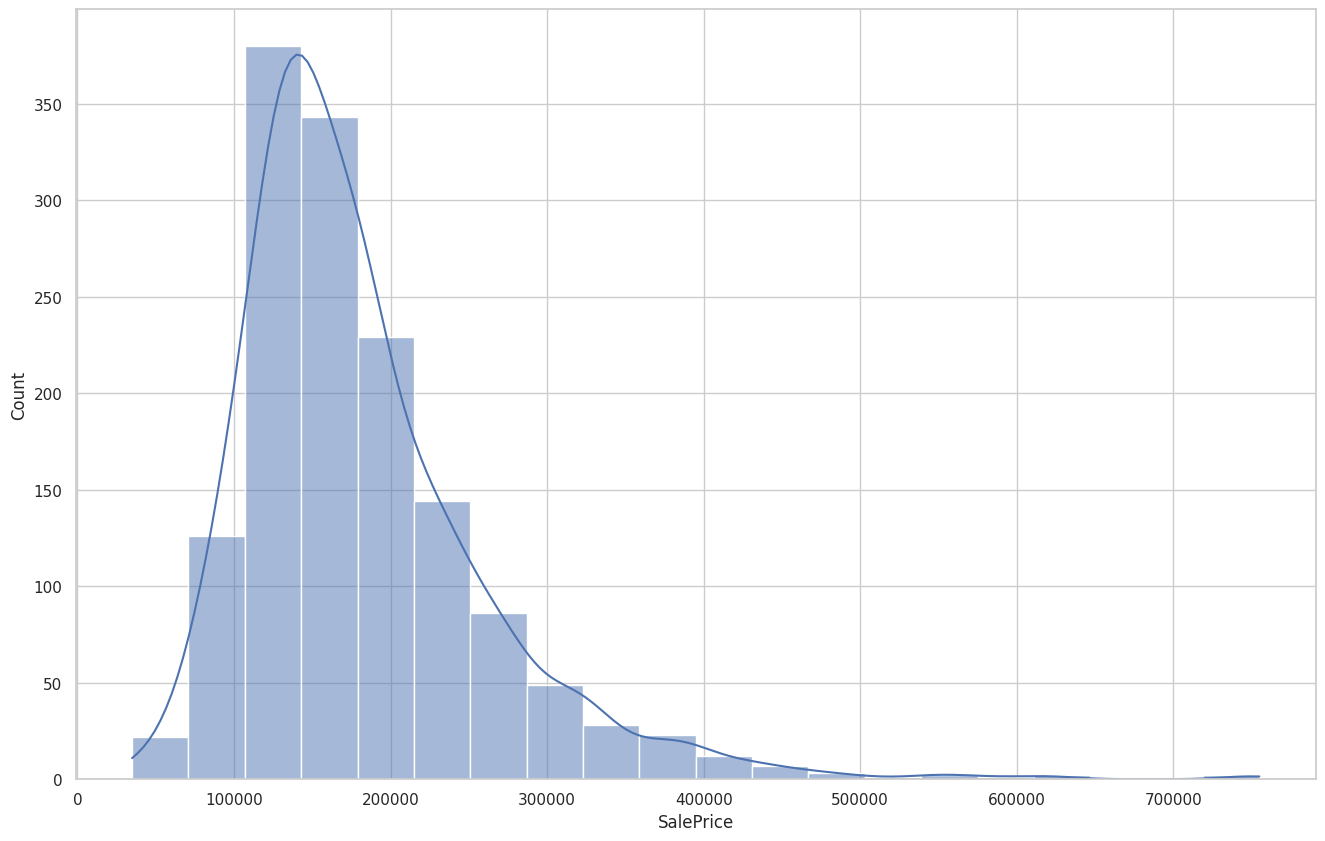

In [12]:
sns.histplot(union_df['SalePrice'], bins=20, kde=True)
plt.show()

скошено вправо. есть выбросы. сделаем нормирование цены `SalePrice`. используем log1p

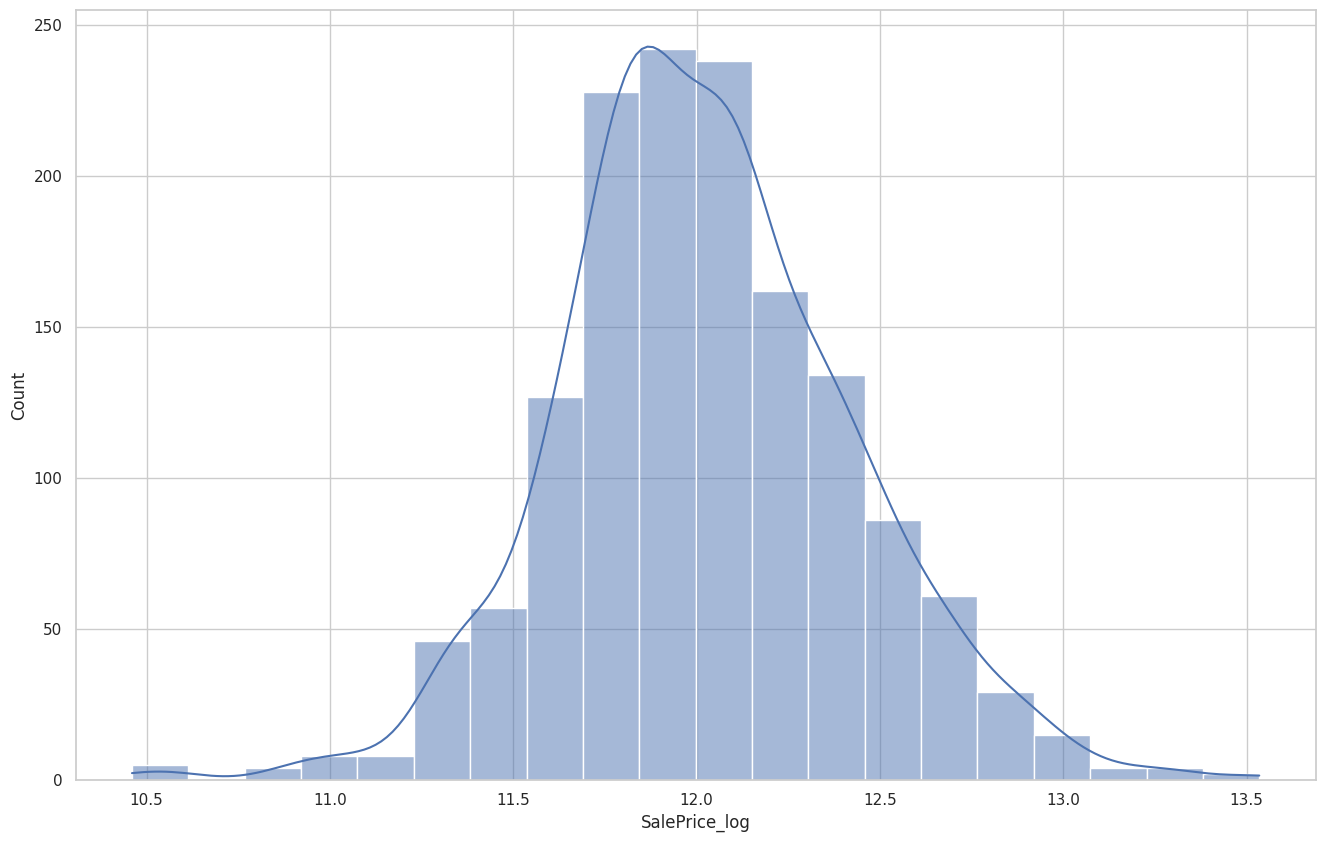

In [13]:
union_df['SalePrice_log'] = np.log1p(union_df['SalePrice'])
# scaler = RobustScaler()
# union_df['SalePrice_log_scaled'] = scaler.fit_transform(union_df[['SalePrice_log']])
sns.histplot(union_df['SalePrice_log'], bins=20, kde=True)
plt.show()

после нормирования значения стали приближены к нормальным

In [14]:
union_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   str    
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   str    
 5   Alley          198 non-null    str    
 6   LotShape       2919 non-null   str    
 7   LandContour    2919 non-null   str    
 8   Utilities      2917 non-null   str    
 9   LotConfig      2919 non-null   str    
 10  LandSlope      2919 non-null   str    
 11  Neighborhood   2919 non-null   str    
 12  Condition1     2919 non-null   str    
 13  Condition2     2919 non-null   str    
 14  BldgType       2919 non-null   str    
 15  HouseStyle     2919 non-null   str    
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt      2919

In [15]:
num_cols = union_df.select_dtypes(include='number').columns.tolist()
len(num_cols)

39

In [16]:
obj_cols = union_df.select_dtypes(include='object').columns.tolist()
len(obj_cols)

43

Графики числовых переменных

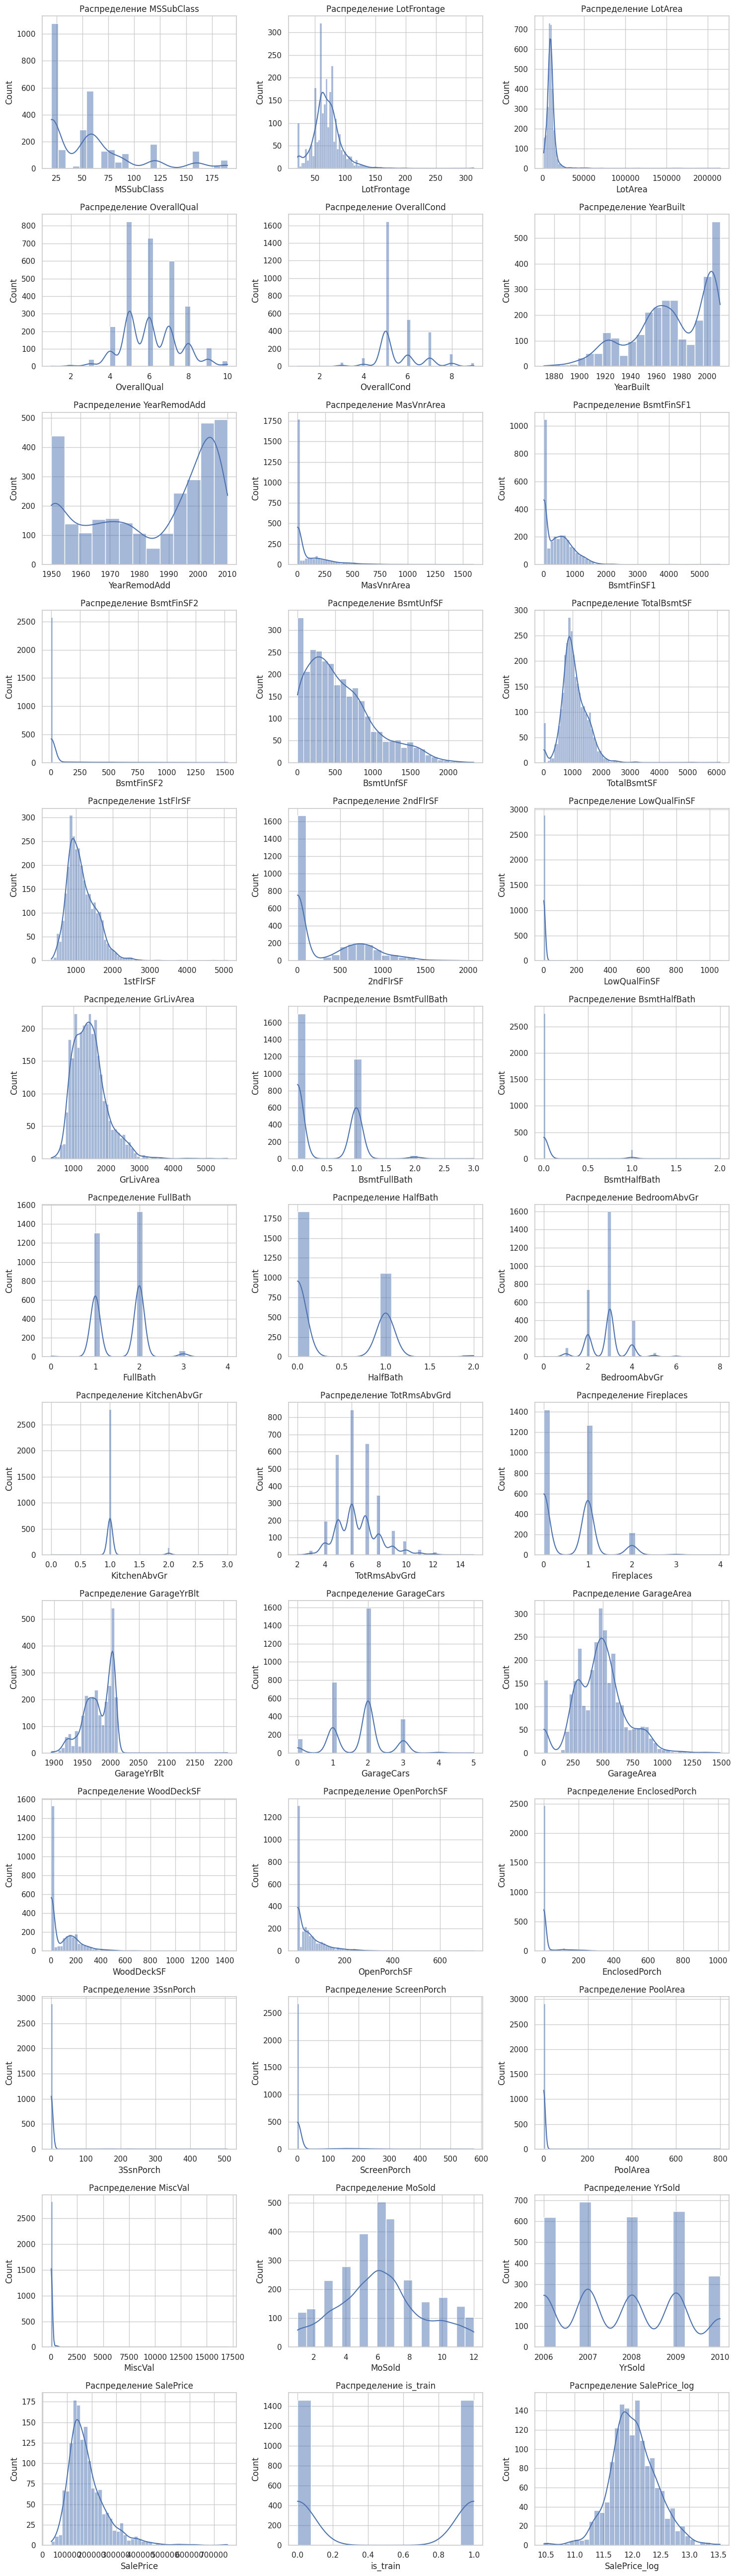

In [17]:
plot_numer(union_df)

Графики категориальных переменных

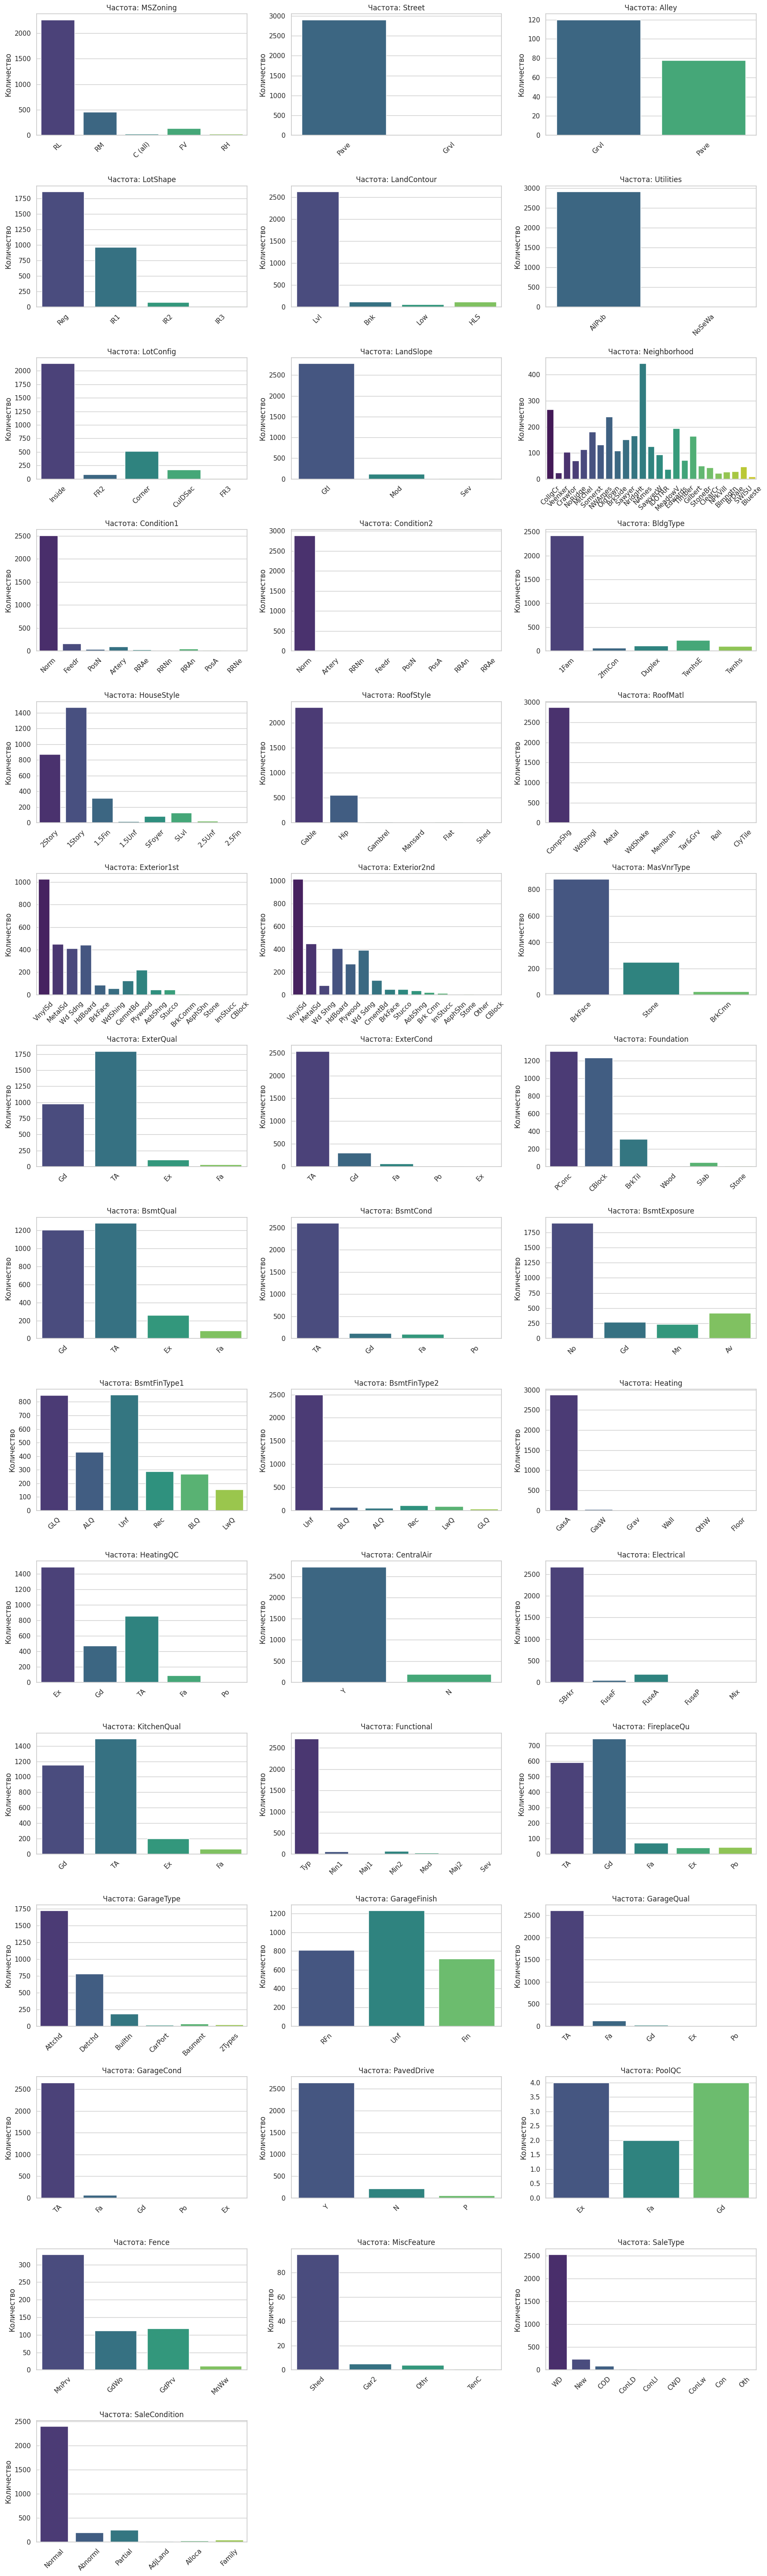

In [18]:
plot_cat(union_df)

In [19]:
correlations = union_df.corr(numeric_only=True)['SalePrice'].sort_values(key=lambda x: abs(x), ascending=False)
print(correlations)

SalePrice        1.000000
SalePrice_log    0.948374
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
is_train    

наибольшая корреляция у:

    SalePrice        1.000000
    SalePrice_log    0.948374
    OverallQual      0.790982
    GrLivArea        0.708624
    GarageCars       0.640409
    GarageArea       0.623431

HEATMAP Числовых переменных

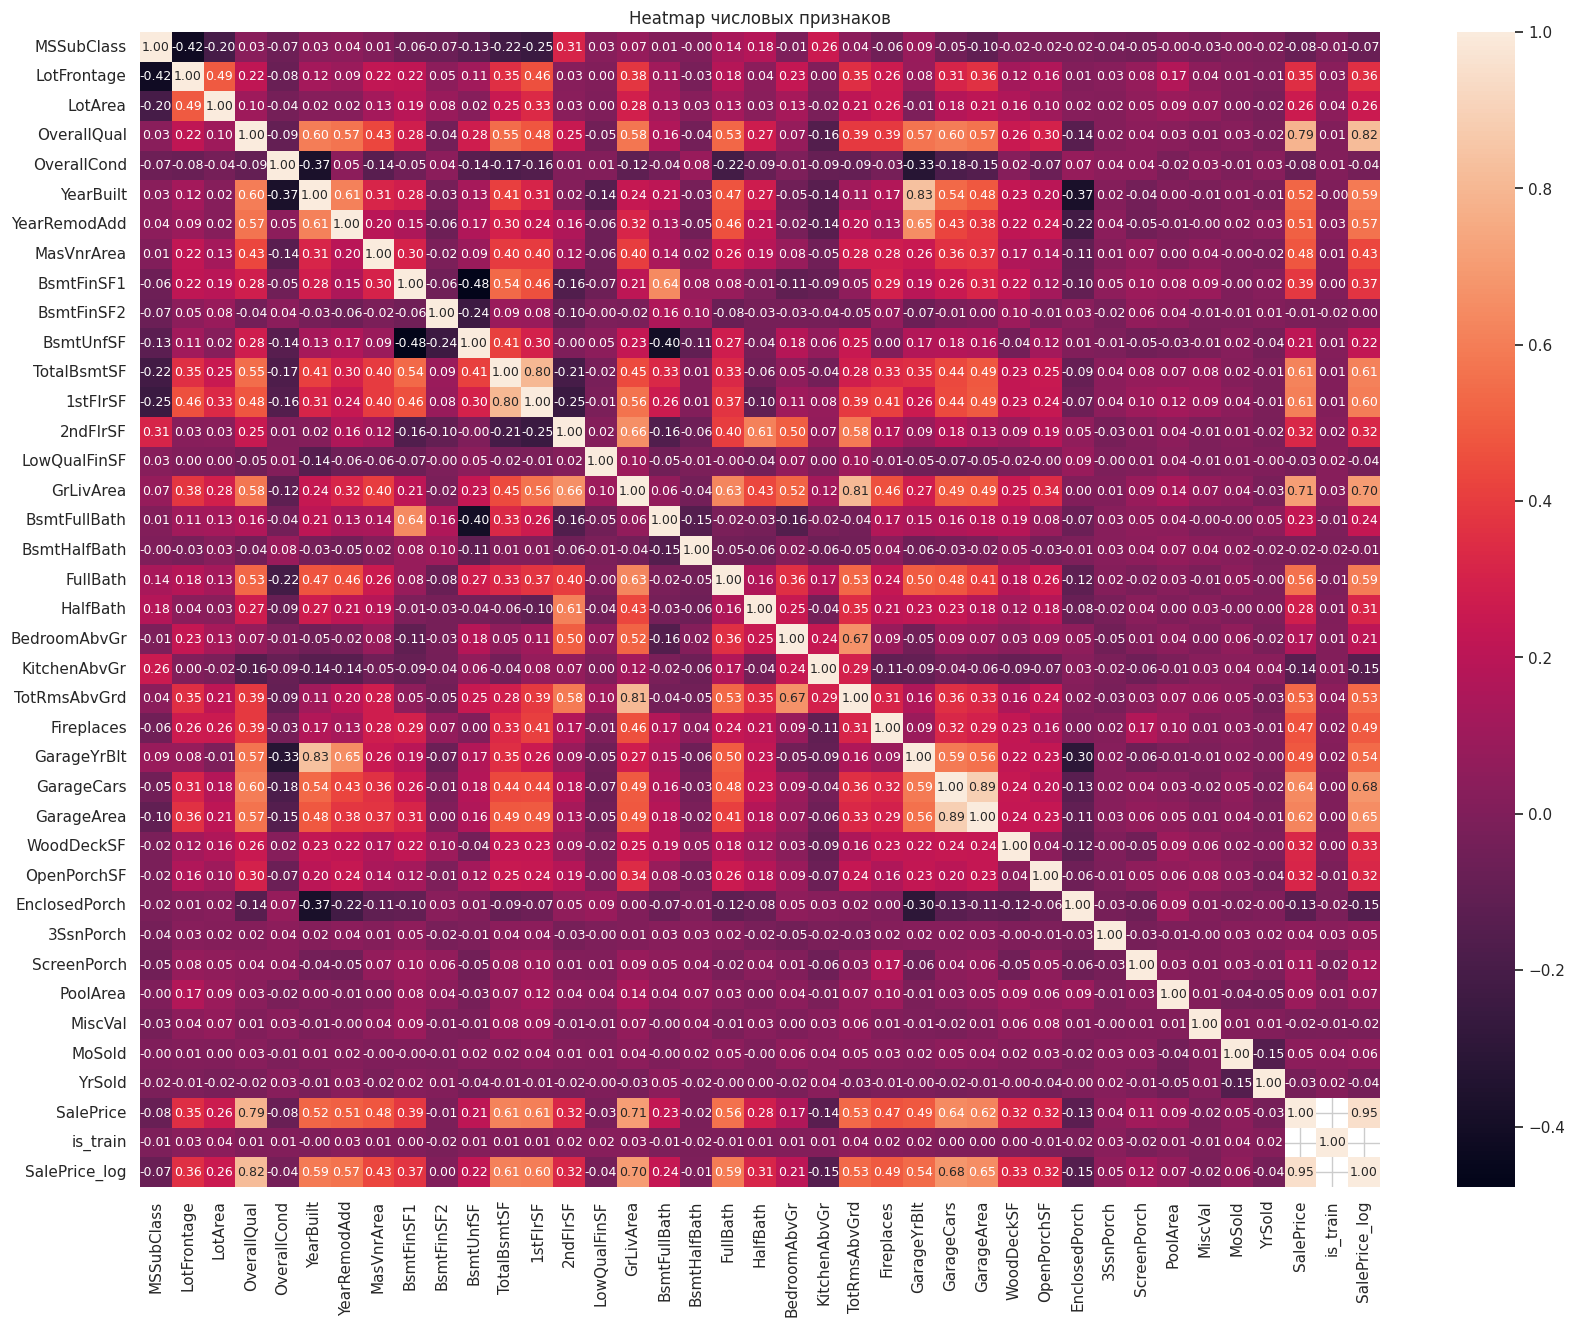

In [20]:
plt.figure(figsize=(20,15))
correlations = union_df.corr(numeric_only=True)
sns.heatmap(correlations, annot=True, fmt='.2f',annot_kws={'size': 9})
plt.title('Heatmap числовых признаков')
plt.show()

In [21]:
union_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   str    
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   str    
 5   Alley          198 non-null    str    
 6   LotShape       2919 non-null   str    
 7   LandContour    2919 non-null   str    
 8   Utilities      2917 non-null   str    
 9   LotConfig      2919 non-null   str    
 10  LandSlope      2919 non-null   str    
 11  Neighborhood   2919 non-null   str    
 12  Condition1     2919 non-null   str    
 13  Condition2     2919 non-null   str    
 14  BldgType       2919 non-null   str    
 15  HouseStyle     2919 non-null   str    
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt      2919

In [22]:
# проверям пропуски
pd.DataFrame(data={'NaN_count': union_df.isna().mean(), 'data_type':union_df.dtypes}).sort_values(by='NaN_count', ascending=False)

NaN_count data_type
PoolQC          0.996574       str
MiscFeature     0.964029       str
Alley           0.932169       str
Fence           0.804385       str
MasVnrType      0.605002       str
SalePrice_log   0.499829   float64
SalePrice       0.499829   float64
FireplaceQu     0.486468       str
LotFrontage     0.166495   float64
GarageFinish    0.054471       str
GarageQual      0.054471       str
GarageYrBlt     0.054471   float64
GarageCond      0.054471       str
GarageType      0.053786       str
BsmtExposure    0.028092       str
BsmtCond        0.028092       str
BsmtQual        0.027749       str
BsmtFinType2    0.027407       str
BsmtFinType1    0.027064       str
MasVnrArea      0.007879   float64
MSZoning        0.001370       str
BsmtFullBath    0.000685   float64
Functional      0.000685       str
BsmtHalfBath    0.000685   float64
Utilities       0.000685       str
SaleType        0.000343       str
KitchenQual     0.000343       str
BsmtFinSF1      0.000343   float64
TotalBsmtSF     0.000343   float64
Electrical      0.000343       str
BsmtFinSF2      0.000343   float64
BsmtUnfSF       0.000343   float64
GarageCars      0.000343   float64
GarageArea      0.000343   float64
Exterior1st     0.000343       str
Exterior2nd     0.000343       str
OverallCond     0.000000     int64
OverallQual     0.000000     int64
Condition2      0.000000       str
Condition1      0.000000       str
HouseStyle      0.000000       str
BldgType        0.000000       str
LotConfig       0.000000       str
LandContour     0.000000       str
LotShape        0.000000       str
Street          0.000000       str
LotArea         0.000000     int64
MSSubClass      0.000000     int64
Neighborhood    0.000000       str
LandSlope       0.000000       str
HalfBath        0.000000     int64
FullBath        0.000000     int64
LowQualFinSF    0.000000     int64
GrLivArea       0.000000     int64
2ndFlrSF        0.000000     int64
1stFlrSF        0.000000     int64
HeatingQC       0.000000       str
CentralAir      0.000000       str
Heating         0.000000       str
YearRemodAdd    0.000000     int64
RoofStyle       0.000000       str
RoofMatl        0.000000       str
YearBuilt       0.000000     int64
Foundation      0.000000       str
ExterQual       0.000000       str
ExterCond       0.000000       str
WoodDeckSF      0.000000     int64
PavedDrive      0.000000       str
BedroomAbvGr    0.000000     int64
Fireplaces      0.000000     int64
TotRmsAbvGrd    0.000000     int64
KitchenAbvGr    0.000000     int64
ScreenPorch     0.000000     int64
OpenPorchSF     0.000000     int64
PoolArea        0.000000     int64
EnclosedPorch   0.000000     int64
3SsnPorch       0.000000     int64
MiscVal         0.000000     int64
YrSold          0.000000     int64
MoSold          0.000000     int64
SaleCondition   0.000000       str
is_train        0.000000     int64


GarageCond	0.054471	str             NA	No Garage       Состояние гаража
GarageType	0.053786	str             NA  No Garage          Тип гаража
BsmtFinType2	0.027407	str         NA	No Basement     Тип отделки остальной площади подвала (если есть)
BsmtFullBath	0.000685	float64     BsmtFullBath: Basement full bathrooms                                                       median
Functional	0.000685	str             Home functionality (Assume typical unless deductions are warranted)                         mode
GarageCars	0.000343	float64         Size of garage in car capacity зависимость от площади
BsmtUnfSF	0.000343	float64         Unfinished square feet of basement area
KitchenQual	0.000343	str             Kitchen quality Ex	Excellent, Gd	Good, TA	Typical/Average, Fa	Fair, Po	Poor        mode
GarageArea	0.000343	float64         GarageArea: Size of garage in square feet                                                   зависимость от количества машин
Electrical	0.000343	str             Electrical: Electrical system                                                               mode
TotalBsmtSF	0.000343	float64         TotalBsmtSF: Total square feet of basement area       площадь                                      median посмотреть на группировку по площади дома

заполняем пропуски NA для строковых переменных в которых это показывает отсутствие на строку 'None'. так как в описание указано что это отсутствие

числовые поля BsmtFullBath, BsmtUnfSF, GarageCars, GarageArea заполнить 0. Если бы были то обязательно заполнили бы, так как это влияет на цену

['Functional', 'Electrical', 'KitchenQual'] - заполняем модой, так как это случайные пропуски электричество в доме должно быть, как и кухня как и Functional общее состояние дома

In [23]:
# 1. Списки признаков
# drop_cols = ['PoolQC']
cols_fillna_0 = ['MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 
                 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea']

cols_fillna_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
                    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                    'BsmtFinType2', 'MasVnrType']

cols_fillna_mode = ['MSZoning', 'Utilities', 'SaleType', 'KitchenQual', 
                    'Electrical', 'Exterior1st', 'Exterior2nd']

In [24]:
imputer = ColumnTransformer([
    # Подаем LotFrontage, Neighborhood, GarageYrBlt, YearBuilt и Functional
    ('smart_imputer', HousePricesSmartImputer(), 
     ['LotFrontage', 'Neighborhood', 'GarageYrBlt', 'YearBuilt', 'Functional']),
    ('zero', SimpleImputer(strategy='constant', fill_value=0), cols_fillna_0),
    ('none', SimpleImputer(strategy='constant', fill_value='None'), cols_fillna_none),
    ('mode', SimpleImputer(strategy='most_frequent'), cols_fillna_mode)
], remainder='passthrough', verbose_feature_names_out=False)

In [25]:
union_df = imputer.fit_transform(union_df)

In [26]:
# # проверям пропуски
pd.DataFrame(data={'NaN_count': union_df.isna().mean(), 'data_type':union_df.dtypes}).sort_values(by='NaN_count', ascending=False)

NaN_count data_type
SalePrice_log   0.499829   float64
SalePrice       0.499829   float64
GarageYrBlt     0.000000   float64
YearBuilt       0.000000     int64
Functional      0.000000       str
MasVnrArea      0.000000   float64
BsmtFullBath    0.000000   float64
BsmtHalfBath    0.000000   float64
BsmtFinSF1      0.000000   float64
BsmtFinSF2      0.000000   float64
BsmtUnfSF       0.000000   float64
TotalBsmtSF     0.000000   float64
GarageCars      0.000000   float64
GarageArea      0.000000   float64
PoolQC          0.000000       str
MiscFeature     0.000000       str
LotFrontage     0.000000   float64
Neighborhood    0.000000       str
Fence           0.000000       str
Alley           0.000000       str
FireplaceQu     0.000000       str
GarageType      0.000000       str
GarageCond      0.000000       str
BsmtQual        0.000000       str
GarageFinish    0.000000       str
GarageQual      0.000000       str
BsmtFinType1    0.000000       str
BsmtFinType2    0.000000       str
MasVnrType      0.000000       str
MSZoning        0.000000       str
Utilities       0.000000       str
SaleType        0.000000       str
BsmtCond        0.000000       str
BsmtExposure    0.000000       str
Exterior1st     0.000000       str
Exterior2nd     0.000000       str
MSSubClass      0.000000     int64
LotArea         0.000000     int64
Street          0.000000       str
LotShape        0.000000       str
LandContour     0.000000       str
LotConfig       0.000000       str
LandSlope       0.000000       str
Condition1      0.000000       str
Condition2      0.000000       str
BldgType        0.000000       str
HouseStyle      0.000000       str
OverallQual     0.000000     int64
KitchenQual     0.000000       str
Electrical      0.000000       str
YearRemodAdd    0.000000     int64
OverallCond     0.000000     int64
RoofStyle       0.000000       str
RoofMatl        0.000000       str
Foundation      0.000000       str
Heating         0.000000       str
ExterQual       0.000000       str
ExterCond       0.000000       str
1stFlrSF        0.000000     int64
2ndFlrSF        0.000000     int64
LowQualFinSF    0.000000     int64
GrLivArea       0.000000     int64
FullBath        0.000000     int64
HalfBath        0.000000     int64
HeatingQC       0.000000       str
CentralAir      0.000000       str
KitchenAbvGr    0.000000     int64
BedroomAbvGr    0.000000     int64
TotRmsAbvGrd    0.000000     int64
Fireplaces      0.000000     int64
OpenPorchSF     0.000000     int64
EnclosedPorch   0.000000     int64
PavedDrive      0.000000       str
WoodDeckSF      0.000000     int64
ScreenPorch     0.000000     int64
3SsnPorch       0.000000     int64
PoolArea        0.000000     int64
MiscVal         0.000000     int64
YrSold          0.000000     int64
MoSold          0.000000     int64
SaleCondition   0.000000       str
is_train        0.000000     int64

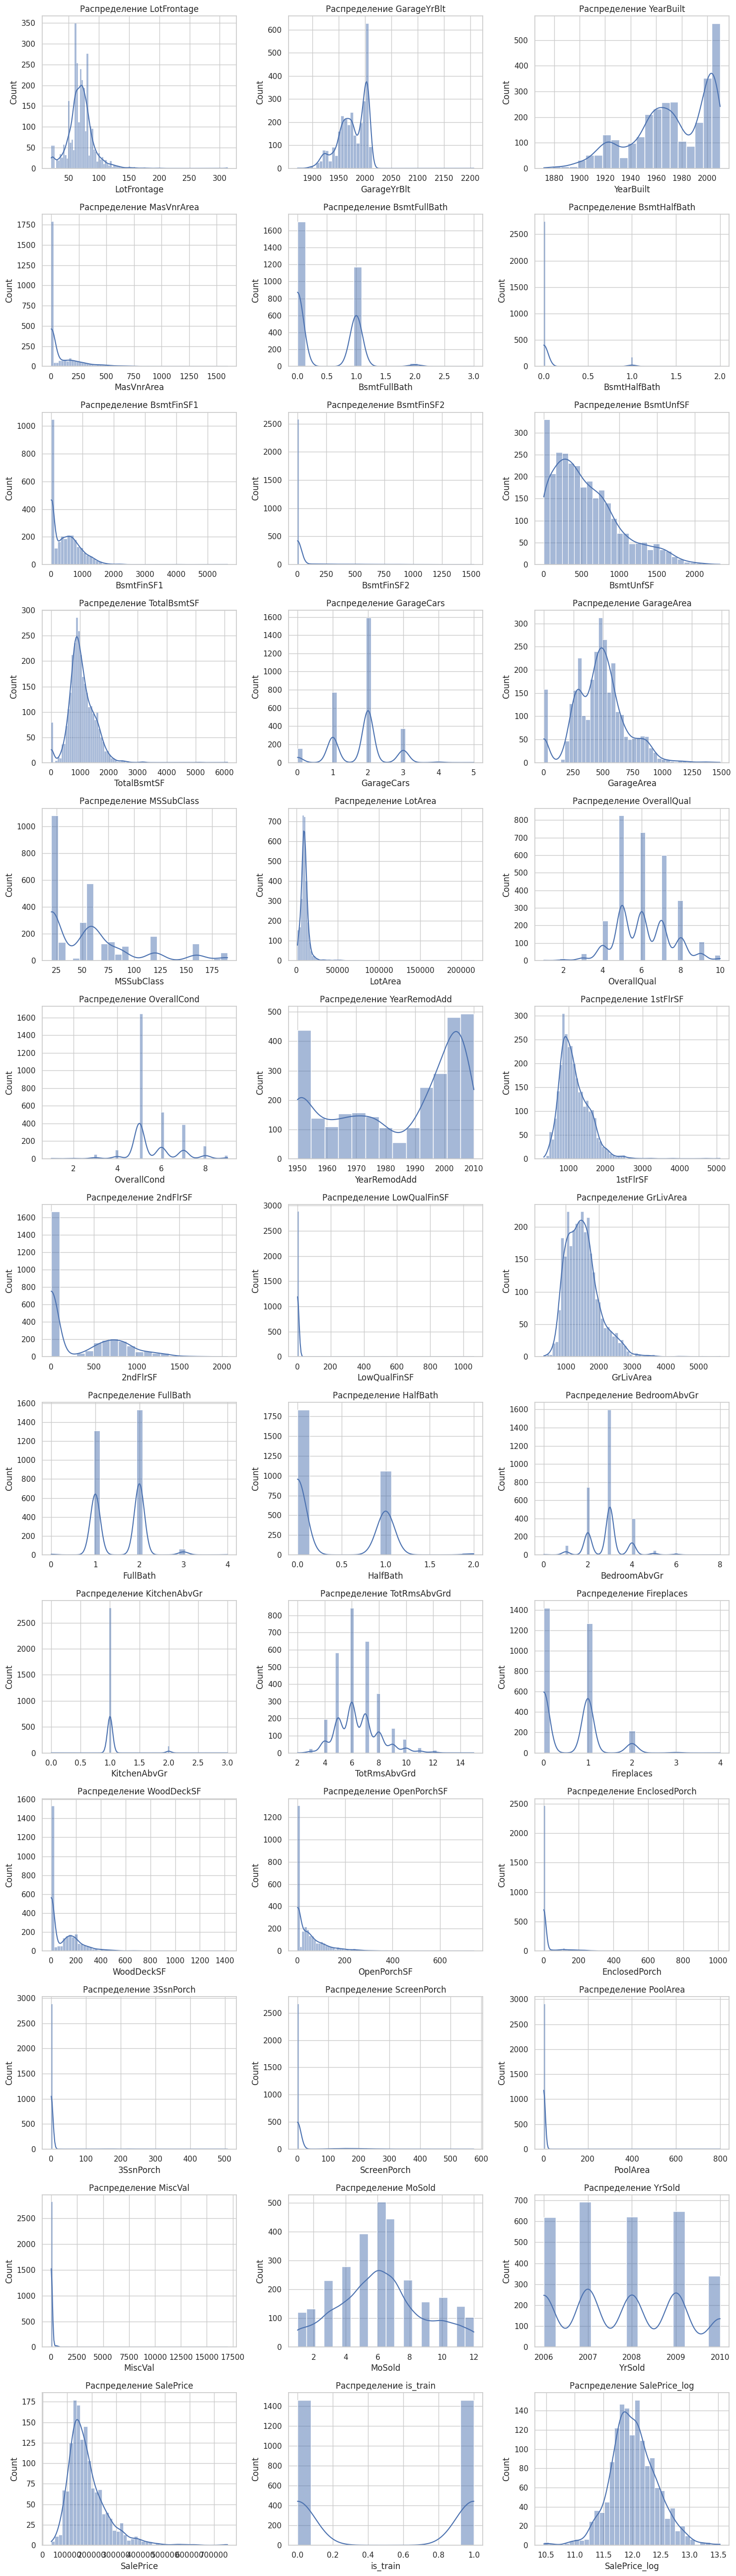

In [27]:
plot_numer(union_df)

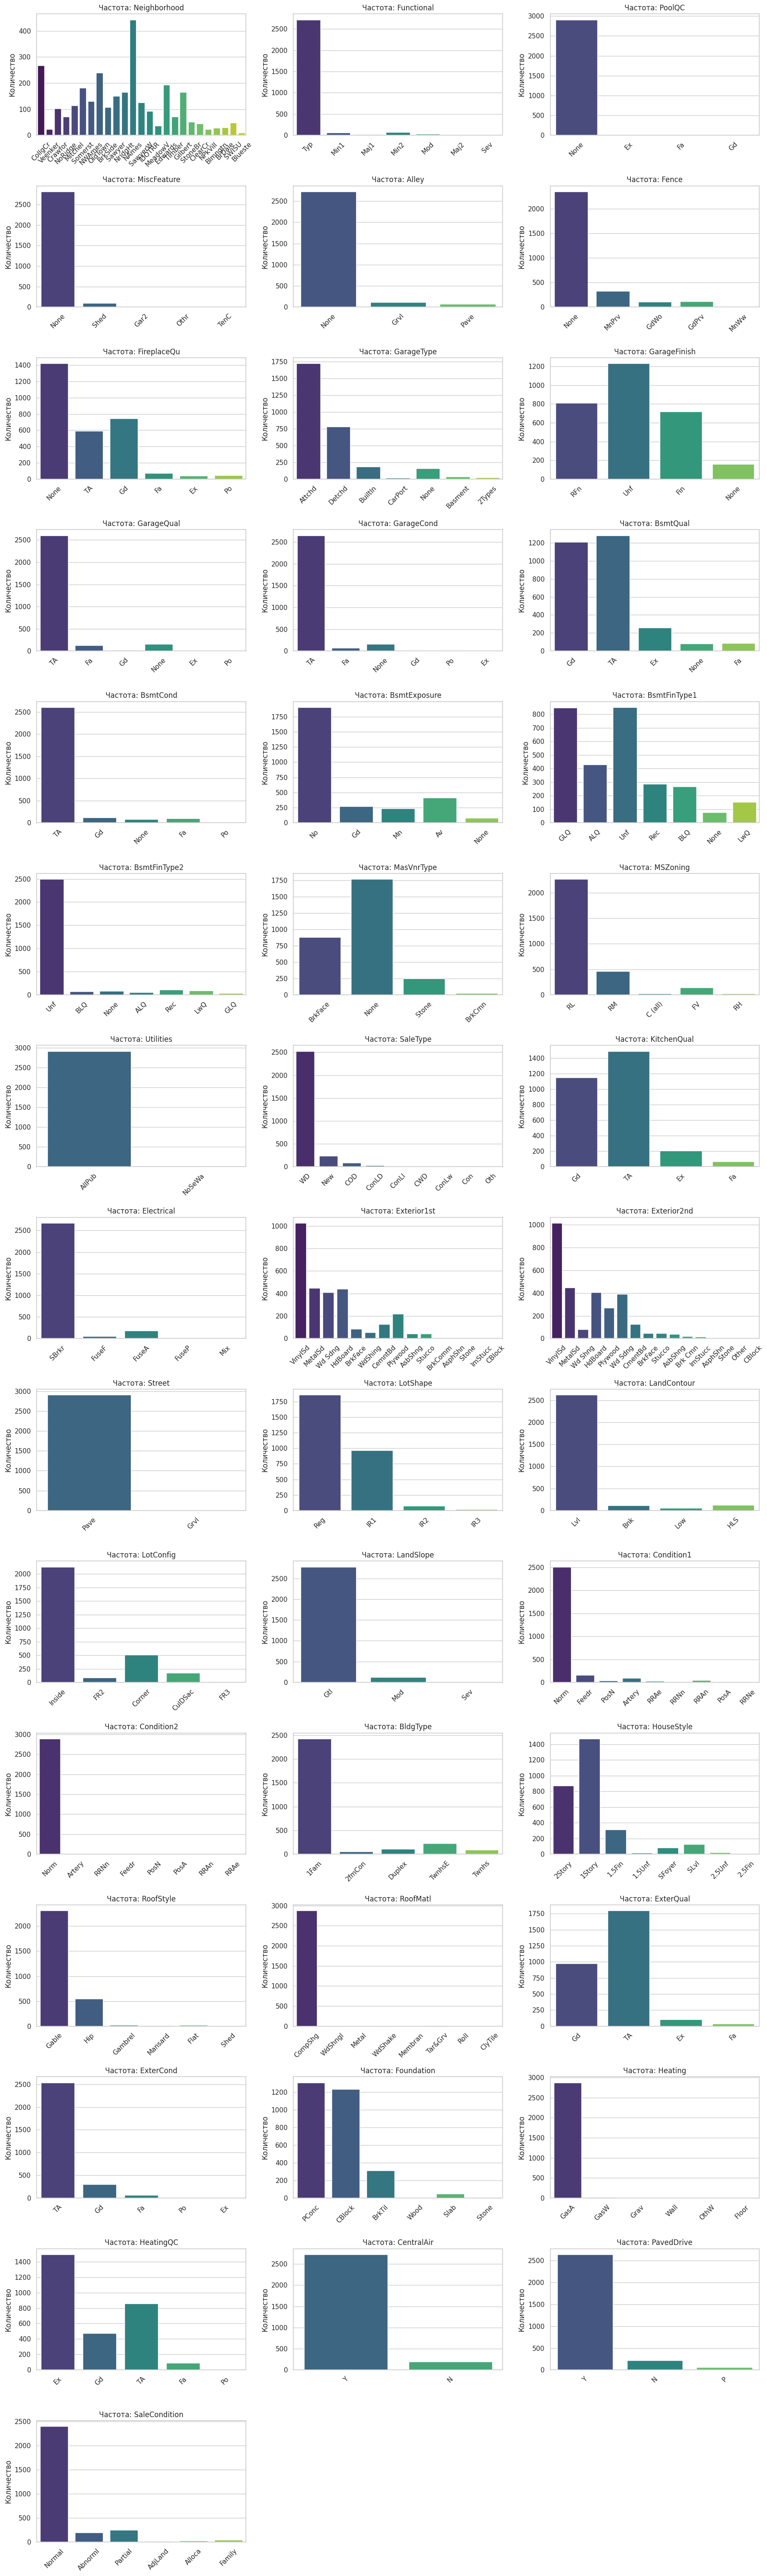

In [28]:
plot_cat(union_df)

In [29]:
union_df = imputer.fit_transform(union_df)

Разделяем выборки

In [30]:
X_train_clean = union_df[union_df['is_train']==1].drop(['SalePrice', 'is_train', 'SalePrice_log'], axis=1).copy()
y_train_clean = union_df[union_df['is_train']==1]['SalePrice_log'].copy()

X_train_clean_imp = union_df[union_df['is_train']==1].drop(['SalePrice', 'is_train'], axis=1).copy()

# X_train_clean, X_valid_clean, y_train_clean, y_valid_clean = train_test_split(X_train_clean_all, 
#                                                                               y_train_clean_all, 
#                                                                               test_size=0.2, 
#                                                                             #   stratify=y_train_clean_all, 
#                                                                               random_state=42)

X_test_clean = union_df[union_df['is_train']==0].drop(['SalePrice', 'is_train', 'SalePrice_log'], axis=1).copy()
X_test_clean.isna().mean().sort_values(ascending=False)

LotFrontage      0.0
Neighborhood     0.0
GarageYrBlt      0.0
YearBuilt        0.0
Functional       0.0
MasVnrArea       0.0
BsmtFullBath     0.0
BsmtHalfBath     0.0
BsmtFinSF1       0.0
BsmtFinSF2       0.0
BsmtUnfSF        0.0
TotalBsmtSF      0.0
GarageCars       0.0
GarageArea       0.0
PoolQC           0.0
MiscFeature      0.0
Alley            0.0
Fence            0.0
FireplaceQu      0.0
GarageType       0.0
GarageFinish     0.0
GarageQual       0.0
GarageCond       0.0
BsmtQual         0.0
BsmtCond         0.0
BsmtExposure     0.0
BsmtFinType1     0.0
BsmtFinType2     0.0
MasVnrType       0.0
MSZoning         0.0
Utilities        0.0
SaleType         0.0
KitchenQual      0.0
Electrical       0.0
Exterior1st      0.0
Exterior2nd      0.0
MSSubClass       0.0
LotArea          0.0
Street           0.0
LotShape         0.0
LandContour      0.0
LotConfig        0.0
LandSlope        0.0
Condition1       0.0
Condition2       0.0
BldgType         0.0
HouseStyle       0.0
OverallQual  

In [31]:
split = 4 # если <=4 то используем onehot если больше то targetenc

# Выбираем только категориальные колонки (object / category)
cat_cols = X_train_clean.select_dtypes(include=['object', 'category']).columns

# Разделяем на OHE и TargetEncoder
col_cat_ohe = [col for col in cat_cols if X_train_clean[col].nunique() <= split]
col_cat_te = [col for col in cat_cols if X_train_clean[col].nunique() > split]

# Числовые колонки
col_num = X_train_clean.select_dtypes(include=['number']).columns


print(f"OneHot: {len(col_cat_ohe)} cols | Target: {len(col_cat_te)} cols | Num: {len(col_num)} cols")

OneHot: 13 cols | Target: 30 cols | Num: 36 cols


In [32]:
encoder = ColumnTransformer(
    transformers=[
        # 1. Простые категории (OneHot)
        # Для бинарных можно добавить drop='if_binary', но для baseline обычно оставляют так
        ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore', sparse_output=False), col_cat_ohe),
        
        # 2. Сложные категории (TargetEncoder)
        ('target_encoding', ce.TargetEncoder(smoothing=10), col_cat_te),
        
        # # 3. Масштабирование всех числовых колонок
        # ('standard_scaler', StandardScaler(), col_num)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)
# X_train_clean = encoder.fit_transform(X_train_clean, y_train_clean)
# X_train_clean.isna().mean().sort_values(ascending=False)

scaler = ColumnTransformer(
    [
        # Применяем RobustScaler ко всем числовым признакам
        ('robust_scaling', RobustScaler(), col_num)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough' 
)
# X_train_clean = scaler.fit_transform(X_train_clean)
# X_train_clean.isna().mean().sort_values(ascending=False)

In [33]:
first_preprocessor = Pipeline([
    # ('imputer', imputer),
    ('encoder', encoder),
    ('scaler', scaler)
])

#Запуск
X_train_pr = first_preprocessor.fit_transform(X_train_clean, y_train_clean)

X_test_pr = first_preprocessor.transform(X_test_clean)



In [34]:
X_test_pr

LotFrontage  GarageYrBlt  YearBuilt  MasVnrArea  BsmtFullBath  \
1460         0.50    -0.404762  -0.260870    0.000000           0.0   
1461         0.55    -0.476190  -0.326087    0.657534           0.0   
1462         0.20     0.452381   0.521739    0.000000           0.0   
1463         0.40     0.476190   0.543478    0.121766           0.0   
1464        -1.35     0.333333   0.413043    0.000000           0.0   
...           ...          ...        ...         ...           ...   
2914        -2.45    -0.190476  -0.065217    0.000000           0.0   
2915        -2.45    -0.190476  -0.065217    0.000000           0.0   
2916         4.50    -0.428571  -0.282609    0.000000           1.0   
2917        -0.40     0.333333   0.413043    0.000000           0.0   
2918         0.20     0.357143   0.434783    0.572298           0.0   

      BsmtHalfBath  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
1460           0.0    0.118638       144.0  -0.354701    -0.217910   
1461           0.0    0.757459         0.0  -0.122222     0.671642   
1462           0.0    0.572131         0.0  -0.582051    -0.126368   
1463           0.0    0.306774         0.0  -0.262393    -0.130348   
1464           0.0   -0.169182         0.0   0.922222     0.574129   
...            ...         ...         ...        ...          ...   
2914           0.0   -0.538435         0.0   0.117094    -0.886567   
2915           0.0   -0.184626         0.0  -0.313675    -0.886567   
2916           0.0    1.180063         0.0  -0.816239     0.462687   
2917           1.0   -0.065286         0.0   0.166667    -0.158209   
2918           0.0    0.525799         0.0  -0.409402     0.008955   

      GarageCars  GarageArea  MSSubClass   LotArea  OverallQual  OverallCond  \
1460        -1.0    1.035197        -0.6  0.529521         -0.5          1.0   
1461        -1.0   -0.695652        -0.6  1.182930          0.0          1.0   
1462         0.0    0.008282         0.2  1.074975         -0.5          0.0   
1463         0.0   -0.041408         0.2  0.123394          0.0          1.0   
1464         0.0    0.107660         1.4 -1.105114          1.0          0.0   
...          ...         ...         ...       ...          ...          ...   
2914        -2.0   -1.987578         2.2 -1.863266         -1.0          2.0   
2915        -1.0   -0.803313         2.2 -1.873641         -1.0          0.0   
2916         0.0    0.397516        -0.6  2.599185         -0.5          2.0   
2917        -2.0   -1.987578         0.7  0.237772         -0.5          0.0   
2918         1.0    0.703934         0.2  0.036685          0.5          0.0   

      YearRemodAdd  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  FullBath  \
1460     -0.891892 -0.375061  0.000000           0.0  -0.877559      -1.0   
1461     -0.972973  0.475209  0.000000           0.0  -0.208575      -1.0   
1462      0.108108 -0.312224  0.962912           0.0   0.254925       0.0   
1463      0.108108 -0.316151  0.931319           0.0   0.216300       0.0   
1464     -0.054054  0.378989  0.000000           0.0  -0.284280       0.0   
...            ...       ...       ...           ...        ...       ...   
2914     -0.648649 -1.062347  0.750000           0.0  -0.574739      -1.0   
2915     -0.648649 -1.062347  0.750000           0.0  -0.574739      -1.0   
2916      0.054054  0.269023  0.000000           0.0  -0.370800      -1.0   
2917     -0.054054 -0.229750  0.000000           0.0  -0.763229      -1.0   
2918      0.000000 -0.178694  1.379121           0.0   0.828119       0.0   

      HalfBath  BedroomAbvGr  KitchenAbvGr  ...  GarageType  GarageQual  \
1460       0.0          -1.0           0.0  ...   12.160783   12.068546   
1461       1.0           0.0           0.0  ...   12.160783   12.068546   
1462       1.0           0.0           0.0  ...   12.160783   12.068546   
1463       1.0           0.0           0.0  ...   12.160783   12.068546   
1464       0.0          -1.0           0.0  ...   1

In [35]:
rfr_baseline = RandomForestRegressor(
    n_estimators=150,      # Число деревьев
    max_depth=None,        # Глубина
    min_samples_leaf=2,    # Минимум объектов в листе
    max_features='sqrt',   # Выбор признаков 
    random_state=42,       # Фиксация результата
    n_jobs=-1              # Скорость
)

# Добавляем модель
baseline_pipeline = Pipeline(steps=[
    ('preprocessing', first_preprocessor),
    ('model', rfr_baseline)
])

In [36]:
baseline_pipeline

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('one_hot_encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['PoolQC',
                                                                    'Alley',
                                                                    'GarageFinish',
                                                                    'MasVnrType',
                                                                    'Utilities',
                                                                    'KitchenQual',
                                                                    'Street',
                                                                    'LotShape',
                                                                    'LandContour',
                                                                    'LandSlope',
                                                                    'ExterQual',
                                                                    'CentralAir',
                                                                    'PavedDrive'...
       'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='str'))],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 RandomForestRegressor(max_features='sqrt', min_samples_leaf=2,
                                       n_estimators=150, n_jobs=-1,
                                       random_state=42))])

In [37]:
rfr_baseline.fit(X_train_pr, y_train_clean)
print('Train - RMSLE:', root_mean_squared_log_error(y_train_clean, rfr_baseline.predict(X_train_pr))) # Доля правильных ответов на выборке, которая была использована для обучения
# print('Valid - RMSLE:', root_mean_squared_log_error(y_valid_clean, rfr_baseline.predict(X_valid_pr))) # Доля правильных ответов на выборке, которую обученный алгоритм еще не видел

Train - RMSLE: 0.005897346478391622


In [38]:
y_test_pred = np.expm1(rfr_baseline.predict(X_test_pr))

submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_test_pred
})

dir_path_out = r'result/'
submission.to_csv(dir_path_out + 'base_dan_submission.csv', index=False)
joblib.dump(rfr_baseline, 'models/ml_baseline_rfr.pkl')

['models/ml_baseline_rfr.pkl']

Результат baseline Kaggle 0,14586

Обработка фич

In [39]:

num_cols_f = X_train_clean_imp.select_dtypes(include='number').columns.tolist()
fet_corr = X_train_clean_imp[num_cols_f].corr()['SalePrice_log'][:-1].sort_values(key=lambda x: abs(x), ascending=False)

# cor_result = ['Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', 'MoSold', '3SsnPorch', 'YrSold', 'LowQualFinSF']

fet_corr

OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
GarageYrBlt      0.568696
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.426776
BsmtFinSF1       0.372023
LotFrontage      0.351234
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
EnclosedPorch   -0.149050
KitchenAbvGr    -0.147548
ScreenPorch      0.121208
MSSubClass      -0.073959
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
LowQualFinSF    -0.037963
YrSold          -0.037263
OverallCond     -0.036868
MiscVal         -0.020021
BsmtHalfBath    -0.005149
BsmtFinSF2       0.004832
Name: SalePrice_log, dtype: float64

признаки имеют сильное влияние на цену

OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771


признаки имеют слабую корреляцию

LowQualFinSF    -0.037963
YrSold          -0.037263
OverallCond     -0.036868
MiscVal         -0.020021
BsmtHalfBath    -0.005149
BsmtFinSF2       0.004832


помня, что признаки PoolQC, MiscFeature, Alley, Fence имеют высокую долю NA более 0,8(нет этого в доме), то вероятно не оказывают влияния на цену

In [40]:
low_res_corr_feat = ['LowQualFinSF', 'YrSold', 'OverallCond', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']

In [41]:
f_test_result = pd.Series(dict(zip(X_train_pr.columns, f_regression(X_train_pr, y_train_clean)[1]))).sort_values()
bad_features = f_test_result[f_test_result > 0.05]
print(f"Найдено {len(bad_features)} бесполезных признаков:")
print(bad_features)

Найдено 18 бесполезных признаков:
MasVnrType_BrkCmn    0.095981
LandContour_Low      0.144177
LowQualFinSF         0.147104
LotShape_IR3         0.149732
YrSold               0.154710
OverallCond          0.159127
LandSlope_Gtl        0.160510
LandSlope_Mod        0.275623
LandSlope_Sev        0.334368
PoolQC_Fa            0.388143
MiscVal              0.444620
PoolQC_Gd            0.483393
Utilities_NoSeWa     0.629609
Utilities_AllPub     0.629609
Alley_Pave           0.657994
LandContour_Lvl      0.700361
BsmtHalfBath         0.844152
BsmtFinSF2           0.853634
dtype: float64


In [42]:
low_pvalue_feat = ['Utilities', 'Street', 'Alley', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'YrSold']

In [43]:
rfr_res_features = pd.Series(dict(zip(X_train_pr.columns, rfr_baseline.feature_importances_))).sort_values(key=lambda x: abs(x), ascending=False)
poor_tree_features = rfr_res_features[rfr_res_features < 0.001]
print("Самые неважные признаки для модели:")
print(poor_tree_features)

Самые неважные признаки для модели:
Electrical            0.000992
Functional            0.000949
ScreenPorch           0.000939
LandSlope_Gtl         0.000939
GarageFinish_RFn      0.000907
LandContour_Lvl       0.000683
MasVnrType_BrkFace    0.000673
BsmtFinSF2            0.000559
MasVnrType_Stone      0.000473
Heating               0.000426
LandContour_Bnk       0.000416
LandSlope_Mod         0.000401
LandContour_Low       0.000373
Alley_Pave            0.000366
RoofMatl              0.000319
MiscVal               0.000290
LandContour_HLS       0.000261
Alley_None            0.000238
Alley_Grvl            0.000210
BsmtHalfBath          0.000200
MiscFeature           0.000199
LandSlope_Sev         0.000138
LowQualFinSF          0.000130
PavedDrive_P          0.000118
3SsnPorch             0.000062
Street_Grvl           0.000059
Condition2            0.000057
LotShape_IR2          0.000057
MasVnrType_BrkCmn     0.000047
Street_Pave           0.000039
LotShape_IR3          0.000028
Poo

In [44]:
# помня что есть много пропусков в 'Street', 'Alley' и анализируя предыдущие тесты удаляем 
features_to_drop = [
    # много пропусков и низкая важность или всего 1 важный признак
    'Utilities',   
    'Street',      
    'PoolArea',     
    'PoolQC',        
    'Condition2',    
    'RoofMatl',      
    'Heating',       

    # шум (p-value > 0.1 или важность < 0.001) ---
    'LowQualFinSF', 
    '3SsnPorch',    
    'MiscFeature', 
    'MiscVal',       
    'Alley',        
    'BsmtHalfBath',
    'BsmtFinSF2',    
    
    # слабое влияние или шум
    'LandSlope',
    'LandContour',  
#    'YrSold',       
    'MoSold'    
]

# Очищаем список для заполнения нулями
cols_fillna_0 = [c for c in [
    'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 
    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea'
] if c not in features_to_drop]

# Очищаем список для заполнения 'None'
cols_fillna_none = [c for c in [
    'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinType2', 'MasVnrType'
] if c not in features_to_drop]

# Очищаем список для заполнения модой
cols_fillna_mode = [c for c in [
    'MSZoning', 'Utilities', 'SaleType', 'KitchenQual', 
    'Electrical', 'Exterior1st', 'Exterior2nd'
] if c not in features_to_drop]

print(f"Осталось в 0: {len(cols_fillna_0)} | в None: {len(cols_fillna_none)} | в Mode: {len(cols_fillna_mode)}")

imputer = ColumnTransformer([
    ('drop_features', 'drop', features_to_drop),
    # Подаем LotFrontage, Neighborhood, GarageYrBlt, YearBuilt и Functional
    ('smart_imputer', HousePricesSmartImputer(), 
     ['LotFrontage', 'Neighborhood', 'GarageYrBlt', 'YearBuilt', 'Functional']),
    ('zero', SimpleImputer(strategy='constant', fill_value=0), cols_fillna_0),
    ('none', SimpleImputer(strategy='constant', fill_value='None'), cols_fillna_none),
    ('mode', SimpleImputer(strategy='most_frequent'), cols_fillna_mode)
], remainder='passthrough', verbose_feature_names_out=False)


Осталось в 0: 7 | в None: 12 | в Mode: 6


Собираем заново общий файл для проверки

In [45]:
union_df = pd.concat([train, test], ignore_index=True)
union_df['SalePrice_log'] = np.log1p(union_df['SalePrice'])

In [46]:
union_df = imputer.fit_transform(union_df)

In [47]:
# # проверям пропуски
pd.DataFrame(data={'NaN_count': union_df.isna().mean(), 'data_type':union_df.dtypes}).sort_values(by='NaN_count', ascending=False)

NaN_count data_type
SalePrice       0.499829   float64
SalePrice_log   0.499829   float64
LotFrontage     0.000000   float64
Neighborhood    0.000000       str
GarageYrBlt     0.000000   float64
MasVnrArea      0.000000   float64
BsmtFullBath    0.000000   float64
YearBuilt       0.000000     int64
Functional      0.000000       str
TotalBsmtSF     0.000000   float64
GarageCars      0.000000   float64
GarageArea      0.000000   float64
Fence           0.000000       str
FireplaceQu     0.000000       str
GarageType      0.000000       str
BsmtFinSF1      0.000000   float64
BsmtUnfSF       0.000000   float64
GarageCond      0.000000       str
BsmtQual        0.000000       str
BsmtCond        0.000000       str
BsmtExposure    0.000000       str
BsmtFinType1    0.000000       str
BsmtFinType2    0.000000       str
MasVnrType      0.000000       str
MSZoning        0.000000       str
SaleType        0.000000       str
KitchenQual     0.000000       str
Electrical      0.000000       str
Exterior1st     0.000000       str
Exterior2nd     0.000000       str
MSSubClass      0.000000     int64
GarageFinish    0.000000       str
GarageQual      0.000000       str
LotShape        0.000000       str
LotArea         0.000000     int64
LotConfig       0.000000       str
Condition1      0.000000       str
OverallQual     0.000000     int64
OverallCond     0.000000     int64
BldgType        0.000000       str
HouseStyle      0.000000       str
ExterQual       0.000000       str
ExterCond       0.000000       str
Foundation      0.000000       str
HeatingQC       0.000000       str
CentralAir      0.000000       str
1stFlrSF        0.000000     int64
YearRemodAdd    0.000000     int64
RoofStyle       0.000000       str
GrLivArea       0.000000     int64
2ndFlrSF        0.000000     int64
FullBath        0.000000     int64
HalfBath        0.000000     int64
TotRmsAbvGrd    0.000000     int64
Fireplaces      0.000000     int64
BedroomAbvGr    0.000000     int64
KitchenAbvGr    0.000000     int64
WoodDeckSF      0.000000     int64
PavedDrive      0.000000       str
OpenPorchSF     0.000000     int64
EnclosedPorch   0.000000     int64
YrSold          0.000000     int64
ScreenPorch     0.000000     int64
SaleCondition   0.000000       str
is_train        0.000000     int64

In [48]:
X_train_clean_imp_drop = union_df[union_df['is_train']==1].drop(['SalePrice', 'is_train', 'SalePrice_log'], axis=1).copy()
y_train_clean_imp_drop = union_df[union_df['is_train']==1]['SalePrice_log'].copy()

X_train_clean_imp_drop_log = union_df[union_df['is_train']==1].drop(['SalePrice', 'is_train'], axis=1).copy()


X_test_clean_drop = union_df[union_df['is_train']==0].drop(['SalePrice', 'is_train', 'SalePrice_log'], axis=1).copy()
X_test_clean_drop.isna().mean().sort_values(ascending=False)

LotFrontage      0.0
Neighborhood     0.0
GarageYrBlt      0.0
YearBuilt        0.0
Functional       0.0
MasVnrArea       0.0
BsmtFullBath     0.0
BsmtFinSF1       0.0
BsmtUnfSF        0.0
TotalBsmtSF      0.0
GarageCars       0.0
GarageArea       0.0
Fence            0.0
FireplaceQu      0.0
GarageType       0.0
GarageFinish     0.0
GarageQual       0.0
GarageCond       0.0
BsmtQual         0.0
BsmtCond         0.0
BsmtExposure     0.0
BsmtFinType1     0.0
BsmtFinType2     0.0
MasVnrType       0.0
MSZoning         0.0
SaleType         0.0
KitchenQual      0.0
Electrical       0.0
Exterior1st      0.0
Exterior2nd      0.0
MSSubClass       0.0
LotArea          0.0
LotShape         0.0
LotConfig        0.0
Condition1       0.0
BldgType         0.0
HouseStyle       0.0
OverallQual      0.0
OverallCond      0.0
YearRemodAdd     0.0
RoofStyle        0.0
ExterQual        0.0
ExterCond        0.0
Foundation       0.0
HeatingQC        0.0
CentralAir       0.0
1stFlrSF         0.0
2ndFlrSF     

In [49]:
split = 4 # если <=4 то используем onehot если больше то targetenc

# Выбираем только категориальные колонки (object / category)
cat_cols = X_train_clean_imp_drop.select_dtypes(include=['object', 'category']).columns

# Разделяем на OHE и TargetEncoder
col_cat_ohe = [col for col in cat_cols if X_train_clean_imp_drop[col].nunique() <= split]
col_cat_te = [col for col in cat_cols if X_train_clean_imp_drop[col].nunique() > split]

# Числовые колонки
col_num = X_train_clean_imp_drop.select_dtypes(include=['number']).columns
# col_num_0 = ['BsmtFullBath', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'MasVnrArea']
# col_num_median = [c for c in col_num if c not in col_num_0]

print(f"OneHot: {len(col_cat_ohe)} cols | Target: {len(col_cat_te)} cols | Num: {len(col_num)} cols")

OneHot: 7 cols | Target: 26 cols | Num: 29 cols


In [50]:
encoder = ColumnTransformer(
    transformers=[
        # 1. Простые категории (OneHot)
        # Для бинарных можно добавить drop='if_binary', но для baseline обычно оставляют так
        ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore', sparse_output=False), col_cat_ohe),
        
        # 2. Сложные категории (TargetEncoder)
        ('target_encoding', ce.TargetEncoder(smoothing=10), col_cat_te),
        
        # 3. Масштабирование всех числовых колонок
        ('standard_scaler', StandardScaler(), col_num)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)
# X_train_clean = encoder.fit_transform(X_train_clean, y_train_clean)
# X_train_clean.isna().mean().sort_values(ascending=False)

scaler = ColumnTransformer(
    [
        # Применяем RobustScaler ко всем числовым признакам
        ('robust_scaling', RobustScaler(), col_num)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough' 
)
# X_train_clean = scaler.fit_transform(X_train_clean)
# X_train_clean.isna().mean().sort_values(ascending=False)

пересобираем препроцессор encoder и scaler

In [51]:
preprocessor = Pipeline([
    # ('imputer', imputer),
    ('encoder', encoder),
    ('scaler', scaler)
])

In [52]:
X_train_drop_new = preprocessor.fit_transform(X_train_clean_imp_drop, y_train_clean_imp_drop)

X_test_drop_new = preprocessor.transform(X_test_clean_drop)

In [53]:
X_test_drop_new.isna().mean().sort_values(ascending=False)

LotFrontage           0.0
GarageYrBlt           0.0
YearBuilt             0.0
MasVnrArea            0.0
BsmtFullBath          0.0
BsmtFinSF1            0.0
BsmtUnfSF             0.0
TotalBsmtSF           0.0
GarageCars            0.0
GarageArea            0.0
MSSubClass            0.0
LotArea               0.0
OverallQual           0.0
OverallCond           0.0
YearRemodAdd          0.0
1stFlrSF              0.0
2ndFlrSF              0.0
GrLivArea             0.0
FullBath              0.0
HalfBath              0.0
BedroomAbvGr          0.0
KitchenAbvGr          0.0
TotRmsAbvGrd          0.0
Fireplaces            0.0
WoodDeckSF            0.0
OpenPorchSF           0.0
EnclosedPorch         0.0
ScreenPorch           0.0
YrSold                0.0
GarageFinish_Fin      0.0
GarageFinish_None     0.0
GarageFinish_RFn      0.0
GarageFinish_Unf      0.0
MasVnrType_BrkCmn     0.0
MasVnrType_BrkFace    0.0
MasVnrType_None       0.0
MasVnrType_Stone      0.0
KitchenQual_Ex        0.0
KitchenQual_

Обучаем модель на очищенных данных снова

In [54]:
rfr_baseline.fit(X_train_drop_new, y_train_clean_imp_drop)
print('Train - RMSLE:', root_mean_squared_log_error(y_train_clean_imp_drop, rfr_baseline.predict(X_train_drop_new))) # Доля правильных ответов на выборке, которая была использована для обучения
# print('Valid - RMSLE:', root_mean_squared_log_error(y_valid_clean, rfr_baseline.predict(X_valid_pr))) # Доля правильных ответов на выборке, которую обученный алгоритм еще не видел

Train - RMSLE: 0.005839208901807253


In [55]:
y_test_pred = np.expm1(rfr_baseline.predict(X_test_drop_new))

submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_test_pred
})

dir_path_out = r'result/'
submission.to_csv(dir_path_out + 'drop_dan_submission.csv', index=False)
joblib.dump(rfr_baseline, 'models/ml_baseline_rfr_drop.pkl')

['models/ml_baseline_rfr_drop.pkl']

Смотрим зависимость через Shap

In [56]:
from catboost import CatBoostRegressor
shap.initjs()

In [57]:
X, y = X_train_drop_new, y_train_clean_imp_drop

In [58]:
y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice_log, Length: 1460, dtype: float64

In [59]:
X.isna().mean().sort_values(ascending=False)

LotFrontage           0.0
GarageYrBlt           0.0
YearBuilt             0.0
MasVnrArea            0.0
BsmtFullBath          0.0
BsmtFinSF1            0.0
BsmtUnfSF             0.0
TotalBsmtSF           0.0
GarageCars            0.0
GarageArea            0.0
MSSubClass            0.0
LotArea               0.0
OverallQual           0.0
OverallCond           0.0
YearRemodAdd          0.0
1stFlrSF              0.0
2ndFlrSF              0.0
GrLivArea             0.0
FullBath              0.0
HalfBath              0.0
BedroomAbvGr          0.0
KitchenAbvGr          0.0
TotRmsAbvGrd          0.0
Fireplaces            0.0
WoodDeckSF            0.0
OpenPorchSF           0.0
EnclosedPorch         0.0
ScreenPorch           0.0
YrSold                0.0
GarageFinish_Fin      0.0
GarageFinish_None     0.0
GarageFinish_RFn      0.0
GarageFinish_Unf      0.0
MasVnrType_BrkCmn     0.0
MasVnrType_BrkFace    0.0
MasVnrType_None       0.0
MasVnrType_Stone      0.0
KitchenQual_Ex        0.0
KitchenQual_

In [60]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=42)
model.fit(X, y, verbose=False, plot=False)

In [61]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

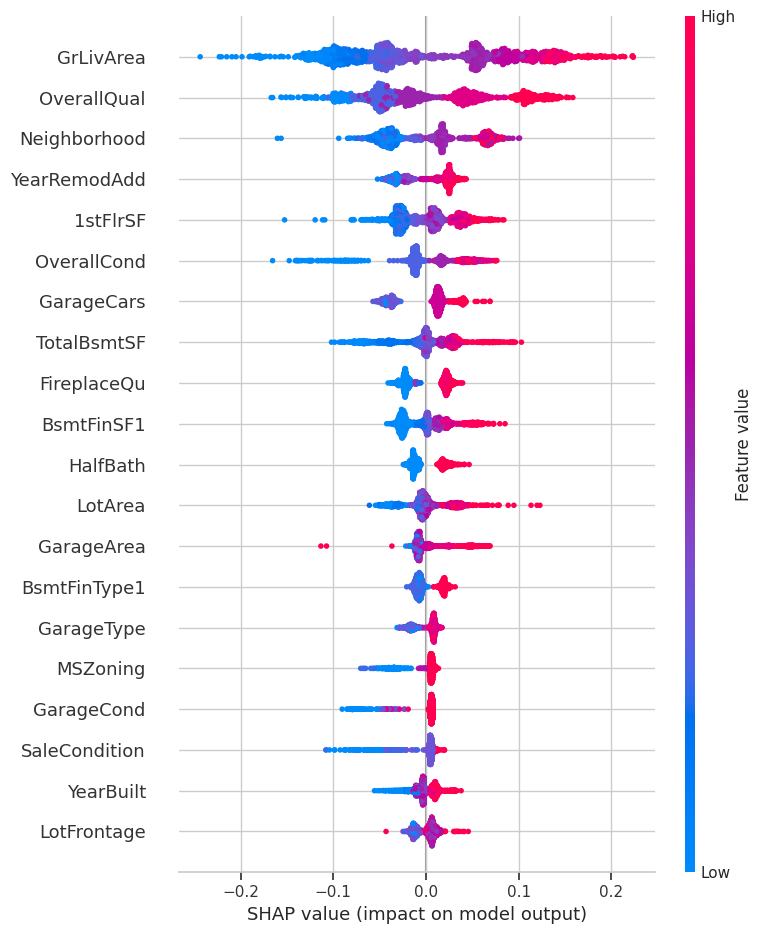

In [62]:
shap.summary_plot(shap_values, X)

In [63]:
# from sklearn.metrics import make_scorer, mean_squared_error

# def rmse_scorer_func(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# neg_rmse_scorer = make_scorer(rmse_scorer_func, greater_is_better=False)

# # 2. Функция, которую Optuna будет запускать много раз
# def objective(trial):
    
#     # Диапазоны параметров, которые Optuna будет перебирать
#     rf_params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
#         'max_depth': trial.suggest_int('max_depth', 3, 20),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
#         'random_state': 42,
#     }
    
#     # Создаем модель с текущим набором параметров
#     model = RandomForestRegressor(**rf_params)

#     # Настраиваем кросс-валидацию (5 фолдов)
#     cv = KFold(n_splits=5, random_state=42, shuffle=True)

#     # Считаем средний скор по кросс-валидации
#     # cross_val_score возвращает отрицательные значения, т.к. мы минимизируем RMSE
#     scores = cross_val_score(model, X_train_drop_new, y_train_clean_imp_drop, cv=cv, scoring=neg_rmse_scorer)
    
#     # Возвращаем среднее отрицательное значение
#     return scores.mean()

# # 3. Запуск оптимизации
# # direction='maximize' + negative RMSE = минимизация RMSE
# study = optuna.create_study(direction='maximize') 

# # Запускаем 100 попыток (trials), n_jobs=6 для распараллеливания
# study.optimize(objective, n_trials=100, n_jobs=6)

# # 4. Вывод результатов
# best_params = study.best_params
# # Превращаем отрицательный скор обратно в положительный RMSE
# best_value_rmse = -study.best_value

# print(f"Лучшие параметры: {best_params}")
# print(f"Лучшее RMSE на кросс-валидации: {best_value_rmse:.4f}")

# # Финальная модель с лучшими параметрами
# best_model = RandomForestRegressor(random_state=42, **best_params)

Лучшие параметры: {'n_estimators': 300, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}
Лучшее RMSE на кросс-валидации: 0.1425

In [64]:
rfr_optuna = RandomForestRegressor(
    n_estimators=300,
    max_depth=14,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=None,  
    random_state=42, 
    n_jobs=-1
)


# Добавляем модель
optuna_pipeline = Pipeline(steps=[
    # ('preprocessing', preprocessor),
    ('model', rfr_optuna)
])

optuna_pipeline


Pipeline(steps=[('model',
                 RandomForestRegressor(max_depth=14, max_features=None,
                                       min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=300, n_jobs=-1,
                                       random_state=42))])

X_train_drop_new, y_train_clean_imp_drop

In [65]:
optuna_pipeline.fit(X_train_drop_new, y_train_clean_imp_drop)
print('Train - RMSLE:', root_mean_squared_log_error(y_train_clean_imp_drop, optuna_pipeline.predict(X_train_drop_new))) # Доля правильных ответов на выборке, которая была использована для обучения
# print('Valid - RMSLE:', root_mean_squared_log_error(y_valid_clean, rfr_baseline.predict(X_valid_pr))) # Доля правильных ответов на выборке, которую обученный алгоритм еще не видел

Train - RMSLE: 0.005003553162585823


In [66]:
y_test_pred = np.expm1(optuna_pipeline.predict(X_test_drop_new))

submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_test_pred
})

dir_path_out = r'result/'
submission.to_csv(dir_path_out + 'optuna_dan_submission.csv', index=False)
joblib.dump(rfr_baseline, 'models/ml_baseline_optuna.pkl')

['models/ml_baseline_optuna.pkl']

результат на kaggggle 0.142

Новые фичи

In [67]:
    
preprocessor = Pipeline([
    ('imputer', imputer),
    ('fe', HousePricesFeatureEngineer()),
    ('encoder', encoder),
    ('scaler', scaler)
    # ('drop_corr', MulticollinearityDropper(threshold=0.99))
])

In [68]:
X_tr = train.drop(['SalePrice', 'is_train'], axis=1).copy()
y_tr_log = np.log1p(train['SalePrice']).copy()
X_test = test

In [69]:
X_train_work = preprocessor.fit_transform(X_tr, y_tr_log)
X_test_work = preprocessor.transform(X_test)

In [70]:
optuna_pipeline.fit(X_train_work, y_tr_log)
print('Train - RMSLE:', root_mean_squared_log_error(y_tr_log, optuna_pipeline.predict(X_train_work))) # Доля правильных ответов на выборке, которая была использована для обучения

Train - RMSLE: 0.0049847922718034765


In [71]:
y_test_pred = np.expm1(optuna_pipeline.predict(X_test_work))

submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_test_pred
})

dir_path_out = r'result/'
submission.to_csv(dir_path_out + 'drop_up_dan_submission.csv', index=False)
joblib.dump(rfr_baseline, 'models/ml_baseline_rfr_drop_up.pkl')

['models/ml_baseline_rfr_drop_up.pkl']

kaggle 0.14098

## Ансамбль

In [72]:
# 1. Инициализируем модели
rf = RandomForestRegressor(n_estimators=300,
                            max_depth=14,
                            min_samples_split=5,
                            min_samples_leaf=2,
                            max_features=None,  
                            random_state=42, 
                            n_jobs=-1)
lgbm = LGBMRegressor(n_estimators=2000, learning_rate=0.01, random_state=42, verbose=-1)
cat = CatBoostRegressor(iterations=2000, learning_rate=0.01, verbose=0, random_state=42)
xgb = XGBRegressor(n_estimators=2000, learning_rate=0.01, max_depth=5, random_state=42)


cat.__sklearn_tags__ = lambda: CatBoostTags()
cat._estimator_type = "regressor"

# 3. Создаем ансамбль
ensemble = VotingRegressor(estimators=[
    ('rf', rf),
    ('lgbm', lgbm),
    ('cat', cat),
    ('xgb', xgb)
], weights=[0.1, 0.3, 0.3, 0.3])

# 4. Обучение
# Убедись, что X_train_work и y_tr_log подготовлены выше
ensemble.fit(X_train_work, y_tr_log)

# 5. Проверка точности
from sklearn.metrics import mean_squared_error
train_preds_log = ensemble.predict(X_train_work)
rmsle_train = np.sqrt(mean_squared_error(y_tr_log, train_preds_log))


print(f'RMSLE: {rmsle_train:.5f}')


RMSLE: 0.03778


In [73]:
print('Train - RMSLE:', root_mean_squared_log_error(y_tr_log, train_preds_log))

Train - RMSLE: 0.0029391065345563613


In [74]:
preds_log = ensemble.predict(X_test_work)
y_test_pred = np.expm1(preds_log)

submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_test_pred
})

dir_path_out = r'result/'
submission.to_csv(dir_path_out + 'ensemble_rfr_lgbm_catb_dan_submission.csv', index=False)
joblib.dump(ensemble, 'models/ml_ensemble_rfr_lgbm_catb.pkl')

['models/ml_ensemble_rfr_lgbm_catb.pkl']

In [76]:
def objective(trial):
    #  диапазоны параметров для каждой модели
    lgbm_params = {
        'n_estimators': trial.suggest_int('lgbm_n', 500, 2000),
        'learning_rate': trial.suggest_float('lgbm_lr', 0.01, 0.1),
        'num_leaves': trial.suggest_int('lgbm_leaves', 20, 150),
        'max_depth': trial.suggest_int('lgbm_depth', 3, 12),
    }
    
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n', 500, 2000),
        'learning_rate': trial.suggest_float('xgb_lr', 0.01, 0.1),
        'max_depth': trial.suggest_int('xgb_depth', 3, 10),
        'subsample': trial.suggest_float('xgb_sub', 0.5, 1.0),
    }

    cat_params = {
        'iterations': trial.suggest_int('cat_n', 500, 2000),
        'learning_rate': trial.suggest_float('cat_lr', 0.01, 0.1),
        'depth': trial.suggest_int('cat_depth', 4, 10),
        'l2_leaf_reg': trial.suggest_int('cat_l2', 1, 10),
        'verbose': 0
    }

    # 2. Инициализируем модели с предложенными параметрами
    lgbm = LGBMRegressor(**lgbm_params, random_state=42)
    xgb = XGBRegressor(**xgb_params, random_state=42)
    cat = CatBoostRegressor(**cat_params, random_state=42) # Тот класс с фиксом тегов

    # 3. Создаем ансамбль
    ensemble = VotingRegressor(estimators=[
        ('lgbm', lgbm), ('xgb', xgb), ('cat', cat)
    ])

    # 4. Считаем качество через кросс-валидацию
    score = cross_val_score(ensemble, X_train_work, y_tr_log, 
                            cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    
    return np.sqrt(-score.mean())

# Запуск поиска
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10) # Чем больше trials, тем лучше результат

print("Лучшие параметры:", study.best_params)
best = study.best_params

[I 2026-01-30 18:15:22,691] A new study created in memory with name: no-name-903d459a-eaaf-45e4-8a9b-bd1bdebc5f5b
[W 2026-01-30 18:15:22,721] Trial 0 failed with parameters: {'lgbm_n': 1816, 'lgbm_lr': 0.07143076973354368, 'lgbm_leaves': 54, 'lgbm_depth': 7, 'xgb_n': 1974, 'xgb_lr': 0.09868443850154263, 'xgb_depth': 4, 'xgb_sub': 0.6944140158942629, 'cat_n': 1336, 'cat_lr': 0.08644628379846413, 'cat_depth': 7, 'cat_l2': 6} because of the following error: ValueError('\nAll the 3 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n3 fits failed with the following error:\nTraceback (most recent call last):\n  File "/home/andre/Elbrus-DataScience/lessons/project_elb/house-prices-kaggle/House-prices-kaggle/env/lib/python3.12/site-packages/sklearn/utils/_tags.py", line 275, in get_tags\

ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/andre/Elbrus-DataScience/lessons/project_elb/house-prices-kaggle/House-prices-kaggle/env/lib/python3.12/site-packages/sklearn/utils/_tags.py", line 275, in get_tags
    tags = estimator.__sklearn_tags__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'CatBoostRegressor' object has no attribute '__sklearn_tags__'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/andre/Elbrus-DataScience/lessons/project_elb/house-prices-kaggle/House-prices-kaggle/env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/andre/Elbrus-DataScience/lessons/project_elb/house-prices-kaggle/House-prices-kaggle/env/lib/python3.12/site-packages/sklearn/base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/andre/Elbrus-DataScience/lessons/project_elb/house-prices-kaggle/House-prices-kaggle/env/lib/python3.12/site-packages/sklearn/ensemble/_voting.py", line 678, in fit
    return super().fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/andre/Elbrus-DataScience/lessons/project_elb/house-prices-kaggle/House-prices-kaggle/env/lib/python3.12/site-packages/sklearn/ensemble/_voting.py", line 80, in fit
    names, clfs = self._validate_estimators()
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/andre/Elbrus-DataScience/lessons/project_elb/house-prices-kaggle/House-prices-kaggle/env/lib/python3.12/site-packages/sklearn/ensemble/_base.py", line 242, in _validate_estimators
    if est != "drop" and not is_estimator_type(est):
                             ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/andre/Elbrus-DataScience/lessons/project_elb/house-prices-kaggle/House-prices-kaggle/env/lib/python3.12/site-packages/sklearn/base.py", line 1242, in is_regressor
    return get_tags(estimator).estimator_type == "regressor"
           ^^^^^^^^^^^^^^^^^^^
  File "/home/andre/Elbrus-DataScience/lessons/project_elb/house-prices-kaggle/House-prices-kaggle/env/lib/python3.12/site-packages/sklearn/utils/_tags.py", line 283, in get_tags
    raise AttributeError(
AttributeError: The following error was raised: 'CatBoostRegressor' object has no attribute '__sklearn_tags__'. It seems that there are no classes that implement `__sklearn_tags__` in the MRO and/or all classes in the MRO call `super().__sklearn_tags__()`. Make sure to inherit from `BaseEstimator` which implements `__sklearn_tags__` (or alternatively define `__sklearn_tags__` but we don't recommend this approach). Note that `BaseEstimator` needs to be on the right side of other Mixins in the inheritance order.
